In [22]:
import time
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import DATASETS
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
from tqdm import tqdm
import pickle
import random
import numpy as np
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
import gensim.downloader
from torch import FloatTensor as FT

# Get the interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline

plt.style.use('ggplot')

### Instructions
For this part, fill in the required code and make the notebook work. This wll be very similar to the Skip-Gram model, but a little more difficult. Look for the """ FILL IN """ string to guide you.

In [23]:
# Where do I want to run my job. You can do "cuda" on linux machines.
DEVICE = "cuda" if torch.backends.cuda.is_built() else  "cpu"
# The batch size in Adam or SGD.
BATCH_SIZE = 512
# Number of epochs.
NUM_EPOCHS = 10
# Predict from 2 words the inner word for CBOW.
# I.e. I'll have a window like ["a", "b", "c"] of continuous text (each is a word).
# We'll predict each of wc = ["a", "c"] from "b" = wc for Skip-Gram.
# For CBOW, we'll use ["a", "c"] to predict "b" = wo.
WINDOW = 1

# Negative samples.
K = 4

The text8 Wikipedia corpus. 100M characters.

In [24]:
!du -h text8

du: cannot access 'text8': No such file or directory


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
f = open('/content/drive/MyDrive/Colab Notebooks/text8', 'r')
text = f.read()
# One big string of size 100M.
print(len(text))

100000000


In [27]:
punc = '!"#$%&()*+,-./:;<=>?@[\\]^_\'{|}~\t\n'

# Can do regular expressions here too.
for c in punc:
    if c in text:
        text.replace(c, ' ')

In [28]:
# A very crude tokenizer you get for free: lower case and also split on spaces.
TOKENIZER = get_tokenizer("basic_english")

In [29]:
words = TOKENIZER(text)
f = Counter(words)

In [30]:
len(words)

17005207

In [31]:
text[0:5]

' anar'

In [32]:
# Do a very crude filter on the text which removes all very popular words.
text = [word for word in words if f[word] > 5]

In [33]:
VOCAB = build_vocab_from_iterator([text])

In [34]:
# word -> int hash map.
stoi = VOCAB.get_stoi()
# int -> word hash map.
itos = VOCAB.get_itos() 

In [35]:
stoi['as']

11

In [36]:
# Total number of words.
len(stoi)

63641

In [37]:
f = Counter(text)
# This is the probability that we pick a word in the corpus.
z = {word: f[word] / len(text) for word in f}

In [38]:
threshold = 1e-5
# Probability that word is kept while subsampling.
# This is explained here and sightly differet from the paper: http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
p_keep = {word: (np.sqrt(z[word] / 0.001) + 1)*(0.0001 / z[word]) for word in f}

In [39]:
# This is in the integer space.
train_dataset = [word for word in text if random.random() < p_keep[word]]

# Rebuild the vocabulary.
VOCAB = build_vocab_from_iterator([train_dataset])

In [40]:
len(train_dataset)

7846301

In [41]:
# word -> int mapping.
stoi = VOCAB.get_stoi()
# int -> word mapping.
itos = VOCAB.get_itos() 

In [42]:
# The vocabulary size after we do all the filters.
len(VOCAB)

63641

In [43]:
# The probability we draw something for negative sampling.
f = Counter(train_dataset)
p = torch.zeros(len(VOCAB))

# Downsample frequent words and upsample less frequent.
s = sum([np.power(freq, 0.75) for word, freq in f.items()])        

for word in f:
    p[stoi[word]] = np.power(f[word], 0.75) / s

In [44]:
# Map everything to integers.
train_dataset = [stoi[word] for word in text]

In [45]:
# This just gets the (wc, wo) pairs that are positive - they are seen together!
def get_tokenized_dataset(dataset, verbose=False):
    x_list = []
        
    for i, token in enumerate(dataset):
        m = 1
        
        # Get the left and right tokens.
        start = max(0, i-m)
        left_tokens = dataset[start:i]
        
        end = min(len(dataset)-1, i+m)
        right_tokens = dataset[i+1:end+1]
        
        # Check these are the same length, and if so use them to add a row of data. This should be a list like.
        # [a, c, b] where b is the center word.
        if len(left_tokens) == len(right_tokens):
            w_context = left_tokens + right_tokens
            
            wc = token
                        
            x_list.extend(
                [w_context + [wc]]
            )
            
    return x_list

In [46]:
train_x_list = get_tokenized_dataset(train_dataset, verbose=False)

In [47]:
pickle.dump(train_x_list, open('train_x_list.pkl', 'wb'))

In [48]:
train_x_list = pickle.load(open('train_x_list.pkl', 'rb'))

In [49]:
# These are (wc, wo) pairs. All are y = +1 by design.
train_x_list[:10]

[[5233, 11, 3083],
 [3083, 5, 11],
 [11, 207, 5],
 [5, 1, 207],
 [207, 3133, 1],
 [1, 48, 3133],
 [3133, 60, 48],
 [48, 163, 60],
 [60, 140, 163],
 [163, 741, 140]]

In [50]:
len(train_x_list)// BATCH_SIZE

32579

In [51]:
# The number of things of BATCH_SIZE = 512.
assert(len(train_x_list) // BATCH_SIZE == 32579)

### Set up the dataloader.

In [52]:
train_dl = DataLoader(
    TensorDataset(
        torch.tensor(train_x_list).to(DEVICE),
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [53]:
for xb in train_dl:
    assert(xb[0].shape == (BATCH_SIZE, 3))
    break

### Words we'll use to asses the quality of the model ...

In [54]:
valid_ids = torch.tensor([
    stoi['money'],
    stoi['lion'],
    stoi['africa'],
    stoi['musician'],
    stoi['dance'],
])

### Get the model.

In [55]:
class CBOWNegativeSampling(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(CBOWNegativeSampling, self).__init__()
        self.A = nn.Embedding(vocab_size, embed_dim) # Context vectors - center word.
        self.B = nn.Embedding(vocab_size, embed_dim) # Output vectors - words around the center word.
        self.init_weights()

    def init_weights(self):
        # Is this the best way? Not sure.
        initrange = 0.5
        self.A.weight.data.uniform_(-initrange, initrange)
        self.B.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        # N is the batch size.
        # x is (N, 3)
        
        # Context words are 2m things, m = 1 so w_context is (N, 2) while wc is (N, 1)
        w_context, wc = x[:,0:2], x[:,2]
                
        # Each of these is (N, 2, D) since each context has 2 word.
        # We want this to be (N, D) and this is what we get.
        
        # (N, 2, D)
        a = self.A(w_context)
        
        # (N, D)
        a_avg = torch.mean(a, dim=1)
        
        # Each of these is (N, D) since each target has 1 word.
        b = self.B(wc)
                
        # The product between each context and target vector. Look at the Skip-Gram code.
        # The logits is now (N, 1) since we sum across the final dimension.
        logits = torch.sum(a_avg * b, dim=1)
                
        return logits

In [56]:
@torch.no_grad()
def validate_embeddings(
    model,
    valid_ids,
    itos
):
    """ Validation logic """

    # We will use context embeddings to get the most similar words
    # Other strategies include: using target embeddings, mean embeddings after avaraging context/target
    embedding_weights = model.A.weight
        
    normalized_embeddings = embedding_weights.cpu() / np.sqrt(
        np.sum(embedding_weights.cpu().numpy()**2, axis=1, keepdims=True)
    )

    # Get the embeddings corresponding to valid_term_ids
    valid_embeddings = normalized_embeddings[valid_ids, :]

    # Compute the similarity between valid_term_ids (S) and all the embeddings (V).
    # We do S x d (d x V) => S x D and sort by negative similarity.
    top_k = 10 # Top k items will be displayed.
    similarity = np.dot(valid_embeddings.cpu().numpy(), normalized_embeddings.cpu().numpy().T)

    # Invert similarity matrix to negative
    # Ignore the first one because that would be the same word as the probe word
    similarity_top_k = np.argsort(-similarity, axis=1)[:, 1: top_k+1]

    # Print the output.
    for i, word_id in enumerate(valid_ids):
        # j >= 1 here since we don't want to include the word itself.
        similar_word_str = ', '.join([itos[j] for j in similarity_top_k[i, :] if j >= 1])
        print(f"{itos[word_id]}: {similar_word_str}")

    print('\n')

### Set up the model

In [57]:
LR = 10.0
NUM_EPOCHS = 10
EMBED_DIM = 300

In [58]:
model = CBOWNegativeSampling(len(VOCAB), EMBED_DIM).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# The learning rate is lowered every epoch by 1/10.
# Is this a good idea?
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.1)

In [59]:
model

CBOWNegativeSampling(
  (A): Embedding(63641, 300)
  (B): Embedding(63641, 300)
)

In [60]:
validate_embeddings(model, valid_ids, itos)

money: sixtus, rabelais, vampires, salah, peta, knowingly, botc, coercive, vouchers, choctaw
lion: yount, iee, probabilities, readily, edom, lir, silja, shielding, autocannon, proofing
africa: blount, noir, middleton, fancy, lethe, bitmapped, greenaway, gnat, delimit, relativist
musician: chainsaw, christians, boyington, holberg, praises, uan, hamadan, atheneum, peacock, beretta
dance: naia, curate, grignard, inquisitorial, dss, upland, monothelitism, lasalle, thema, administrated




### Train the model

In [61]:
ratios = []

def train(dataloader, model, optimizer, epoch):
    model.train()
    total_acc, total_count, total_loss, total_batches = 0, 0, 0.0, 0.0
    log_interval = 500
    
    for idx, x_batch in tqdm(enumerate(dataloader)):
        
        x_batch = x_batch[0]
                
        batch_size = x_batch.shape[0]
        
        # Zero the gradient so they don't accumulate.
        optimizer.zero_grad()
        
        logits = model(x_batch)
                        
        # Get the positive samples loss. Notice we use weights here.
        positive_loss = torch.nn.BCEWithLogitsLoss()(input=logits, target=torch.ones(batch_size).to(DEVICE).float())
        
        # For each batch, get some negative samples.
        # We need a total of len(y_batch) * 2* WINDOW * K samples across a batch.
        # We then reshape this batch.
        # These are effectively the output words.
        #print("Batch size: ", batch_size)
        negative_samples = torch.multinomial(p, batch_size*K, replacement=True)
        #print("negative_samples: ", negative_samples.size())
        # Context words are 2m things, m = 1 so w_context is (N, 2) while wc is (N, 1)
        w_context, wc =x_batch[:,0:2].to('cpu'), negative_samples
        
        #print("w_context: ", w_context.size())
        #print("wc: ", wc.size())
        
        """
        if w_context looks like below (batch_size = 3)
        [
        (a, b),
        (c, d),
        (e, f)
        ] and K = 2 we'd like to get:
        
        [
        (a, b),
        (a, b),
        (c, d), 
        (c, d),
        (e, f),
        (e, f)
        ]
        
        This will be batch_size * K rows.
        """
        
        # This should be (N * K, 2)
        w_context = torch.concat([
            w.repeat(K, 1) for w in torch.tensor(w_context).split(1)
        ])
        #print("w_context: ", w_context.size())
        # Remove the last dimension 1.
        wc = wc.view(wc.size()[0],1)
        #print("wc: ", wc.size())
        # Get the negative samples. This should be (N * K, 3).
        # Concatenate the w_context and wc along the column. Make sure everything is on CUDA / MPS or CPU.
        x_batch_negative = torch.concat([w_context, wc], axis=1).to(DEVICE)
        #print("x_batch_negative: ", x_batch_negative.shape)      
        """
        Note the way we formulated the targets: they are all 0 since these are negative samples.
        We do the BCEWithLogitsLoss by hand basically here.
        Notice we sum across the negative samples, per positive word.
        
        This is literally the equation in the lecture notes.
        """
        
        # (N, K, D) -> (N, D) -> (N)
        # Look at the Skip-Gram notebook.
        negative_loss = model(x_batch_negative).neg().sigmoid().log().reshape(
            batch_size, K
        ).sum(1).mean().neg().to(DEVICE)
        
        loss = (positive_loss + negative_loss).mean()
                
        # Get the gradients via back propagation. 
        loss.backward()
                        
        # Clip the gradients? Generally a good idea.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        # Used for optimization. This should be roughly 0.001, on average.
        # You can use this to see if your learning rate is right - you can also plot the loss performance.
        with torch.no_grad():
            r = [
                (LR * p.grad.std() / p.data.std()).log10().item() for _, p in model.named_parameters()
            ]
            ratios.append(r)  
        
        # Do an optimization step. Update the parameters A and B.
        optimizer.step()
        # Get the new loss.
        total_loss += loss.item()
        # Update the batch count.
        total_batches += 1
                
        if idx % log_interval == 0:
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| loss {:8.3f} ".format(
                    epoch,
                    idx,
                    len(dataloader),
                    total_loss / total_batches
                )
            )
            validate_embeddings(model, valid_ids, itos)
            total_loss, total_batches = 0.0, 0.0

### Some results from the run look like below:

Somewhere inside of 2 iterations you should get sensible associattions.
Paste here a screenshot of the closest vectors.

In [62]:
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start_time = time.time()
    
    train(train_dl, model, optimizer, epoch)
    # We have a learning rate scheduler here.
    # Basically, given the state of the optimizer, this lowers the learning rate in a smart way.
    scheduler.step()

0it [00:00, ?it/s]<ipython-input-61-af72c1b5bcb7>:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w.repeat(K, 1) for w in torch.tensor(w_context).split(1)
1it [00:01,  1.87s/it]

| epoch   1 |     0/32580 batches | loss    4.059 
money: sixtus, rabelais, vampires, salah, peta, knowingly, botc, coercive, vouchers, choctaw
lion: yount, iee, probabilities, readily, edom, lir, silja, shielding, autocannon, proofing
africa: blount, noir, middleton, fancy, lethe, bitmapped, greenaway, gnat, delimit, relativist
musician: chainsaw, christians, boyington, holberg, praises, uan, hamadan, atheneum, peacock, beretta
dance: naia, curate, grignard, inquisitorial, dss, upland, monothelitism, lasalle, thema, administrated




502it [00:07, 71.02it/s]

| epoch   1 |   500/32580 batches | loss    3.722 
money: sixtus, rabelais, vampires, union, salah, choctaw, vouchers, coercive, botc, knowingly
lion: yount, readily, iee, probabilities, edom, lir, silja, autocannon, shielding, proofing
africa: blount, noir, middleton, fancy, gnat, greenaway, bitmapped, lethe, delimit, relativist
musician: chainsaw, christians, boyington, holberg, uan, praises, hamadan, atheneum, peacock, magnum
dance: naia, inquisitorial, curate, grignard, dss, upland, monothelitism, administrated, thema, lasalle




1000it [00:12, 90.36it/s]

| epoch   1 |  1000/32580 batches | loss    3.362 
money: rabelais, sixtus, union, salah, vampires, choctaw, coercive, vouchers, botc, abrasives
lion: readily, yount, iee, probabilities, edom, lir, silja, shielding, autocannon, proofing
africa: blount, noir, middleton, bitmapped, fancy, lethe, greenaway, relativist, mbox, gnat
musician: chainsaw, christians, boyington, holberg, uan, praises, hamadan, atheneum, disc, magnum
dance: naia, inquisitorial, curate, grignard, dss, upland, monothelitism, lasalle, thema, administrated




1500it [00:18, 95.37it/s]

| epoch   1 |  1500/32580 batches | loss    3.033 
money: union, salah, rabelais, vampires, sixtus, choctaw, coercive, milk, peta, botc
lion: readily, yount, iee, probabilities, edom, lir, silja, shielding, autocannon, aldgate
africa: blount, noir, fancy, middleton, greenaway, mbox, lethe, bitmapped, cells, relativist
musician: christians, chainsaw, boyington, uan, praises, holberg, hamadan, disc, atheneum, acker
dance: inquisitorial, naia, curate, grignard, dss, upland, monothelitism, thema, lasalle, interglacial




2000it [00:23, 95.69it/s]

| epoch   1 |  2000/32580 batches | loss    2.796 
money: union, salah, rabelais, vampires, choctaw, milk, coercive, peta, sixtus, velar
lion: readily, yount, iee, probabilities, edom, lir, silja, shielding, aldgate, proofing
africa: blount, noir, fancy, mbox, greenaway, middleton, cells, lethe, chilly, relativist
musician: christians, chainsaw, praises, uan, boyington, holberg, hamadan, disc, catastrophism, acker
dance: inquisitorial, curate, grignard, naia, dss, upland, monothelitism, thema, lasalle, interglacial




2500it [00:28, 94.86it/s]

| epoch   1 |  2500/32580 batches | loss    2.630 
money: union, salah, rabelais, vampires, choctaw, milk, rate, coercive, peta, m
lion: readily, yount, probabilities, iee, lir, edom, silja, proofing, aldgate, shielding
africa: noir, blount, fancy, mbox, cells, middleton, greenaway, honours, chilly, relativist
musician: christians, chainsaw, praises, uan, boyington, holberg, hamadan, disc, acker, catastrophism
dance: inquisitorial, grignard, naia, curate, dss, upland, monothelitism, thema, lasalle, fulltext




2999it [00:34, 96.55it/s]

| epoch   1 |  3000/32580 batches | loss    2.488 
money: union, salah, m, rate, choctaw, american, vampires, rabelais, milk, known
lion: readily, yount, probabilities, iee, lir, edom, silja, proofing, aldgate, shielding
africa: noir, blount, many, mbox, fancy, cells, n, team, honours, greenaway
musician: christians, chainsaw, uan, praises, boyington, holberg, hamadan, acker, catastrophism, disc
dance: inquisitorial, curate, dss, grignard, naia, upland, monothelitism, fulltext, thema, lasalle




3499it [00:39, 94.84it/s]

| epoch   1 |  3500/32580 batches | loss    2.379 
money: union, m, american, known, war, rate, salah, choctaw, use, history
lion: readily, yount, probabilities, iee, edom, lir, silja, proofing, giving, aldgate
africa: many, n, noir, team, cells, form, mbox, fancy, blount, out
musician: christians, chainsaw, uan, praises, boyington, holberg, hamadan, catastrophism, disc, acker
dance: inquisitorial, grignard, curate, naia, dss, upland, monothelitism, fulltext, thema, chloride




3999it [00:45, 95.54it/s]

| epoch   1 |  4000/32580 batches | loss    2.297 
money: union, m, known, use, war, american, history, well, rate, an
lion: readily, yount, probabilities, iee, lir, edom, x, silja, giving, proofing
africa: many, n, team, form, use, if, between, noir, what, even
musician: christians, chainsaw, uan, praises, can, x, there, boyington, holberg, hamadan
dance: inquisitorial, curate, grignard, dss, naia, upland, monothelitism, fulltext, catnip, thema




4499it [00:50, 95.25it/s]

| epoch   1 |  4500/32580 batches | loss    2.219 
money: union, m, known, war, use, history, well, american, rate, time
lion: readily, yount, probabilities, iee, lir, x, edom, giving, silja, proofing
africa: many, n, form, use, team, if, what, when, are, between
musician: christians, chainsaw, x, can, uan, some, there, praises, zero, only
dance: inquisitorial, grignard, curate, dss, naia, fulltext, upland, monothelitism, catnip, chloride




4999it [00:55, 96.89it/s]

| epoch   1 |  5000/32580 batches | loss    2.158 
money: union, m, use, well, known, war, history, way, american, g
lion: readily, x, yount, probabilities, lir, giving, sent, iee, edom, among
africa: n, form, many, use, if, what, only, when, even, team
musician: christians, x, can, chainsaw, there, zero, some, uan, b, english
dance: inquisitorial, curate, grignard, contains, dss, naia, fulltext, legacy, catnip, monothelitism




5499it [01:01, 94.78it/s]

| epoch   1 |  5500/32580 batches | loss    2.107 
money: union, m, use, well, known, war, history, way, g, i
lion: readily, x, among, giving, probabilities, sent, yount, after, iee, lir
africa: form, use, n, when, if, many, and, is, what, only
musician: christians, x, zero, can, b, there, english, some, new, n
dance: inquisitorial, contains, among, curate, grignard, legacy, conception, naia, catnip, dss




5999it [01:06, 95.66it/s]

| epoch   1 |  6000/32580 batches | loss    2.059 
money: union, m, well, use, war, known, way, history, g, time
lion: x, readily, among, giving, as, after, sent, died, probabilities, yount
africa: form, use, when, n, and, only, if, even, many, what
musician: christians, b, zero, x, can, there, english, n, seven, would
dance: contains, inquisitorial, among, legacy, curate, conception, grignard, last, opposed, naia




6499it [01:11, 96.01it/s]

| epoch   1 |  6500/32580 batches | loss    2.018 
money: union, well, use, m, war, known, way, g, history, time
lion: x, among, after, readily, giving, died, rule, sent, as, probabilities
africa: form, use, only, and, when, n, part, even, what, many
musician: christians, x, b, zero, there, n, english, can, would, seven
dance: contains, among, inquisitorial, last, conception, legacy, opposed, grignard, curate, usually




6999it [01:17, 93.55it/s]

| epoch   1 |  7000/32580 batches | loss    1.981 
money: union, well, use, m, known, war, way, g, history, time
lion: x, among, giving, after, died, readily, sent, rule, three, past
africa: use, form, only, when, part, many, even, out, what, based
musician: x, christians, b, zero, english, n, new, there, five, only
dance: contains, last, among, opposed, conception, inquisitorial, usually, links, legacy, ii




7499it [01:22, 95.65it/s]

| epoch   1 |  7500/32580 batches | loss    1.945 
money: union, use, well, m, war, known, way, history, g, time
lion: x, among, died, giving, sent, rule, after, readily, three, eight
africa: form, use, part, only, when, even, based, out, those, called
musician: x, b, christians, zero, n, english, five, new, seven, then
dance: contains, last, among, opposed, usually, conception, links, ii, order, legacy




7999it [01:28, 95.78it/s]

| epoch   1 |  8000/32580 batches | loss    1.914 
money: union, use, well, war, m, known, way, history, others, time
lion: x, giving, among, died, sent, three, rule, readily, after, eight
africa: use, form, part, only, and, even, when, based, those, used
musician: x, b, christians, zero, n, english, five, new, did, seven
dance: among, last, contains, opposed, usually, order, links, ii, well, addition




8499it [01:33, 95.40it/s]

| epoch   1 |  8500/32580 batches | loss    1.884 
money: union, use, well, way, known, war, m, others, time, order
lion: giving, x, among, died, sent, rule, eight, three, after, readily
africa: form, use, part, only, based, even, those, what, nine, called
musician: x, b, christians, zero, five, english, seven, n, then, did
dance: among, contains, last, usually, order, opposed, links, case, ii, addition




8998it [01:38, 94.56it/s]

| epoch   1 |  9000/32580 batches | loss    1.858 
money: union, use, well, way, known, war, m, others, order, time
lion: giving, x, died, among, sent, eight, rule, readily, seven, three
africa: use, form, part, those, only, based, what, even, called, south
musician: x, zero, b, english, seven, five, christians, n, did, states
dance: among, contains, last, order, usually, opposed, links, case, ii, well




9497it [01:46, 93.38it/s]

| epoch   1 |  9500/32580 batches | loss    1.838 
money: union, use, well, way, known, m, others, war, order, time
lion: giving, died, among, x, sent, eight, rule, three, six, past
africa: use, form, part, those, what, south, called, nine, even, based
musician: x, b, zero, english, seven, n, states, christians, did, u
dance: contains, last, order, among, links, opposed, usually, addition, case, well




10006it [01:52, 67.18it/s]

| epoch   1 | 10000/32580 batches | loss    1.819 
money: union, use, well, way, others, m, time, known, war, order
lion: giving, died, among, x, sent, eight, rule, six, past, three
africa: use, form, part, south, those, called, nine, what, north, even
musician: x, b, zero, seven, english, n, states, five, u, christians
dance: last, among, contains, order, opposed, usually, addition, links, well, region




10506it [01:57, 68.86it/s]

| epoch   1 | 10500/32580 batches | loss    1.797 
money: use, union, well, way, others, time, known, order, m, war
lion: giving, died, among, rule, x, sent, three, eight, six, after
africa: use, form, part, south, those, nine, north, what, called, even
musician: x, zero, b, english, seven, n, states, u, five, example
dance: last, order, contains, opposed, among, links, addition, region, line, well




11006it [02:03, 67.99it/s]

| epoch   1 | 11000/32580 batches | loss    1.777 
money: use, union, way, well, others, known, time, order, m, form
lion: died, giving, among, x, rule, sent, three, six, eight, after
africa: part, use, form, those, south, called, what, nine, north, article
musician: x, zero, b, n, states, u, seven, example, english, did
dance: order, last, opposed, contains, links, addition, among, well, region, line




11506it [02:08, 68.59it/s]

| epoch   1 | 11500/32580 batches | loss    1.762 
money: use, union, way, well, others, time, known, order, m, form
lion: died, giving, sent, among, rule, x, president, after, six, three
africa: part, form, use, those, south, called, what, nine, article, north
musician: x, zero, b, states, english, n, u, example, seven, did
dance: order, last, contains, links, opposed, addition, region, among, well, line




12004it [02:13, 68.64it/s]

| epoch   1 | 12000/32580 batches | loss    1.739 
money: use, union, way, well, others, time, known, form, order, example
lion: died, giving, sent, as, among, rule, president, six, x, king
africa: part, form, use, south, those, north, called, nine, article, work
musician: x, zero, b, u, states, n, seven, example, english, four
dance: order, contains, addition, opposed, last, links, region, work, well, line




12503it [02:19, 69.63it/s]

| epoch   1 | 12500/32580 batches | loss    1.725 
money: use, way, union, well, others, form, known, example, fact, order
lion: died, giving, sent, rule, among, president, three, x, king, six
africa: part, form, use, south, those, north, work, france, article, what
musician: x, zero, states, b, u, english, example, n, seven, did
dance: order, addition, last, contains, opposed, links, work, region, well, development




13001it [02:24, 71.94it/s]

| epoch   1 | 13000/32580 batches | loss    1.708 
money: use, way, union, well, form, others, example, fact, order, time
lion: died, giving, sent, president, six, rule, king, eight, among, past
africa: part, form, use, south, north, and, france, those, work, nine
musician: x, zero, states, example, b, u, english, did, seven, five
dance: order, addition, contains, opposed, last, links, region, french, work, development




13500it [02:30, 95.07it/s]

| epoch   1 | 13500/32580 batches | loss    1.698 
money: way, use, union, well, fact, example, form, time, others, work
lion: died, giving, president, eight, sent, rule, six, king, three, father
africa: part, form, use, south, north, france, those, nine, article, work
musician: x, zero, example, b, u, states, english, n, did, seven
dance: order, addition, last, opposed, contains, french, region, links, development, work




13999it [02:35, 92.43it/s]

| epoch   1 | 14000/32580 batches | loss    1.685 
money: way, use, union, well, fact, form, example, time, others, work
lion: died, giving, president, six, sent, eight, rule, four, king, as
africa: part, form, south, france, north, use, nine, united, those, article
musician: x, zero, example, u, b, states, english, five, seven, n
dance: order, addition, french, region, last, opposed, links, contains, development, work




14499it [02:40, 95.93it/s]

| epoch   1 | 14500/32580 batches | loss    1.672 
money: way, use, union, well, fact, form, example, work, time, others
lion: died, giving, six, president, sent, eight, rule, king, three, father
africa: part, form, south, north, france, use, united, nine, europe, end
musician: x, zero, example, u, b, english, n, states, fact, christians
dance: order, addition, region, opposed, french, links, country, last, development, study




14999it [02:46, 94.52it/s]

| epoch   1 | 15000/32580 batches | loss    1.659 
money: way, use, union, fact, well, example, work, form, found, time
lion: died, giving, rule, president, sent, six, eight, king, book, father
africa: part, form, south, north, france, use, nine, united, europe, end
musician: zero, x, u, example, fact, seven, b, english, states, five
dance: order, addition, region, opposed, country, french, development, links, last, study




15499it [02:51, 87.04it/s]

| epoch   1 | 15500/32580 batches | loss    1.648 
money: way, use, fact, union, work, well, example, order, possible, time
lion: died, giving, six, president, rule, sent, three, eight, book, five
africa: part, form, south, north, france, nine, use, united, europe, end
musician: zero, x, u, fact, seven, example, english, states, b, did
dance: order, addition, region, french, opposed, country, development, study, links, last




15998it [02:57, 95.95it/s]

| epoch   1 | 16000/32580 batches | loss    1.635 
money: way, use, fact, union, well, work, example, possible, time, found
lion: died, giving, sent, rule, president, six, seven, eight, book, king
africa: part, south, form, north, france, nine, use, europe, united, end
musician: zero, u, fact, x, example, n, seven, states, english, singer
dance: order, addition, french, region, country, opposed, study, last, development, links




16497it [03:02, 92.13it/s]

| epoch   1 | 16500/32580 batches | loss    1.625 
money: way, use, fact, well, work, union, example, possible, form, time
lion: died, giving, six, sent, rule, president, seven, eight, four, five
africa: part, south, form, north, france, europe, end, united, use, nine
musician: zero, fact, u, example, five, x, seven, actress, n, singer
dance: order, addition, french, country, region, study, links, opposed, last, development




17007it [03:08, 67.46it/s]

| epoch   1 | 17000/32580 batches | loss    1.616 
money: way, use, fact, well, work, time, possible, result, union, example
lion: died, giving, six, sent, rule, president, three, seven, eight, four
africa: part, south, north, france, form, europe, united, end, nine, use
musician: zero, fact, u, seven, actress, singer, actor, n, states, x
dance: order, addition, french, country, region, study, links, development, opposed, last




17507it [03:13, 67.58it/s]

| epoch   1 | 17500/32580 batches | loss    1.607 
money: way, use, fact, well, work, result, possible, time, union, example
lion: died, giving, six, sent, rule, three, president, seven, father, four
africa: part, south, north, france, form, europe, nine, united, end, canada
musician: zero, fact, actress, seven, singer, u, actor, states, n, english
dance: order, addition, french, country, links, zero, region, study, last, development




17997it [03:18, 96.35it/s]

| epoch   1 | 18000/32580 batches | loss    1.594 
money: way, use, fact, well, time, work, possible, result, union, example
lion: died, giving, six, sent, four, rule, three, president, father, eight
africa: part, south, north, france, europe, form, united, end, nine, germany
musician: zero, fact, actress, actor, singer, u, seven, n, example, x
dance: order, addition, french, country, zero, region, development, links, study, music




18497it [03:24, 94.66it/s]

| epoch   1 | 18500/32580 batches | loss    1.582 
money: way, fact, use, work, time, well, result, possible, union, example
lion: died, four, giving, six, sent, president, father, rule, three, case
africa: part, south, france, north, europe, united, end, form, nine, germany
musician: zero, actress, fact, actor, singer, u, n, seven, example, nine
dance: addition, order, french, country, study, region, development, music, zero, opposed




19007it [03:29, 68.40it/s]

| epoch   1 | 19000/32580 batches | loss    1.576 
money: way, fact, use, work, well, time, result, possible, union, terms
lion: died, six, four, giving, sent, father, president, three, rule, eight
africa: south, part, north, france, europe, united, end, form, nine, germany
musician: actress, zero, fact, actor, singer, u, n, seven, french, x
dance: addition, order, french, country, study, region, zero, development, opposed, last




19497it [03:35, 96.33it/s]

| epoch   1 | 19500/32580 batches | loss    1.571 
money: way, fact, use, work, result, time, well, possible, terms, play
lion: died, six, four, giving, president, father, sent, rule, addition, case
africa: south, north, part, france, europe, united, end, nine, form, england
musician: actress, zero, singer, fact, actor, u, five, n, seven, nine
dance: addition, order, country, french, study, region, music, zero, opposed, development




19997it [03:40, 94.72it/s]

| epoch   1 | 20000/32580 batches | loss    1.559 
money: way, fact, use, work, result, time, well, possible, union, play
lion: died, four, giving, six, father, president, sent, seven, rule, five
africa: south, north, france, part, europe, united, end, nine, india, germany
musician: actress, singer, zero, fact, actor, u, seven, n, nine, five
dance: addition, order, country, french, study, region, music, development, opposed, spanish




20507it [03:46, 68.60it/s]

| epoch   1 | 20500/32580 batches | loss    1.552 
money: way, fact, use, work, result, time, possible, well, play, example
lion: died, six, four, giving, father, sent, seven, rule, president, three
africa: south, north, france, europe, united, part, nine, end, india, germany
musician: actress, singer, zero, actor, fact, u, n, seven, five, example
dance: addition, order, country, french, study, region, opposed, music, development, spanish




20997it [03:51, 95.06it/s]

| epoch   1 | 21000/32580 batches | loss    1.543 
money: way, fact, use, result, work, time, well, possible, play, example
lion: died, six, father, giving, four, sent, rule, president, seven, addition
africa: south, north, europe, france, united, part, end, india, germany, nine
musician: actress, singer, actor, fact, zero, u, n, seven, example, author
dance: addition, order, country, french, study, opposed, region, music, five, spanish




21507it [03:59, 68.25it/s]

| epoch   1 | 21500/32580 batches | loss    1.540 
money: way, fact, use, result, well, time, work, possible, play, example
lion: died, six, four, father, sent, seven, giving, five, rule, three
africa: south, north, europe, france, united, india, part, end, nine, germany
musician: actress, actor, singer, fact, zero, u, seven, nine, author, example
dance: addition, order, country, french, study, music, opposed, spanish, region, development




22007it [04:04, 68.95it/s]

| epoch   1 | 22000/32580 batches | loss    1.529 
money: way, fact, use, result, time, play, well, work, possible, example
lion: died, four, six, father, seven, sent, rule, giving, president, addition
africa: north, france, south, europe, india, united, end, nine, part, germany
musician: actress, actor, singer, zero, fact, u, seven, five, nine, author
dance: addition, country, order, french, study, music, opposed, development, region, spanish




22507it [04:09, 68.56it/s]

| epoch   1 | 22500/32580 batches | loss    1.523 
money: way, fact, result, use, play, well, time, work, possible, seen
lion: died, seven, six, four, father, sent, eight, five, rule, giving
africa: north, south, france, europe, india, united, end, germany, part, canada
musician: actress, actor, singer, fact, u, zero, seven, nine, five, result
dance: addition, country, order, study, french, music, opposed, region, seven, development




22997it [04:15, 95.87it/s]

| epoch   1 | 23000/32580 batches | loss    1.518 
money: way, fact, result, use, time, play, well, possible, work, seen
lion: died, seven, father, four, six, five, sent, rule, eight, president
africa: south, north, france, europe, india, united, end, germany, part, canada
musician: actress, actor, singer, fact, zero, u, seven, five, nine, author
dance: addition, country, order, french, study, music, opposed, spanish, seven, region




23497it [04:20, 95.38it/s]

| epoch   1 | 23500/32580 batches | loss    1.511 
money: way, fact, result, use, play, time, well, seen, work, possible
lion: died, seven, father, four, six, five, sent, eight, rule, addition
africa: south, north, france, europe, india, end, united, canada, germany, part
musician: actress, actor, singer, fact, zero, u, seven, nine, five, author
dance: addition, country, order, study, french, music, opposed, seven, russian, spanish




23997it [04:25, 96.76it/s]

| epoch   1 | 24000/32580 batches | loss    1.508 
money: way, fact, result, use, play, time, well, seen, possible, work
lion: seven, died, four, father, six, five, sent, addition, rule, eight
africa: south, france, north, europe, india, united, end, germany, canada, america
musician: actress, actor, singer, fact, five, zero, u, nine, seven, author
dance: addition, country, order, study, french, opposed, music, russian, seven, spanish




24497it [04:31, 94.18it/s]

| epoch   1 | 24500/32580 batches | loss    1.500 
money: way, fact, result, use, time, possible, well, play, seen, meaning
lion: died, seven, father, four, five, six, addition, president, sent, eight
africa: south, france, europe, north, india, end, united, america, germany, canada
musician: actress, actor, singer, fact, zero, u, nine, five, author, seven
dance: addition, country, order, study, music, russian, opposed, french, seven, spanish




24997it [04:36, 94.65it/s]

| epoch   1 | 25000/32580 batches | loss    1.495 
money: way, fact, result, use, play, possible, time, well, seen, meaning
lion: died, seven, four, father, five, addition, six, eight, sent, president
africa: france, south, europe, india, north, end, united, germany, canada, america
musician: actress, actor, singer, fact, zero, u, author, seven, nine, five
dance: addition, country, order, study, music, seven, russian, opposed, philosophy, french




25506it [04:42, 68.27it/s]

| epoch   1 | 25500/32580 batches | loss    1.493 
money: way, fact, result, use, play, time, possible, well, meaning, seen
lion: died, four, seven, eight, father, addition, six, three, five, sent
africa: south, france, india, europe, north, end, united, germany, canada, america
musician: actress, actor, singer, zero, fact, nine, seven, u, author, result
dance: country, addition, order, study, music, russian, french, philosophy, opposed, spanish




26004it [04:47, 68.19it/s]

| epoch   1 | 26000/32580 batches | loss    1.482 
money: way, fact, result, use, play, possible, well, time, meaning, seen
lion: eight, died, father, four, three, seven, five, addition, six, president
africa: south, france, india, north, europe, end, united, canada, germany, america
musician: actress, actor, singer, zero, fact, nine, author, u, seven, eight
dance: country, addition, study, order, music, french, spanish, philosophy, eight, russian




26503it [04:53, 68.67it/s]

| epoch   1 | 26500/32580 batches | loss    1.476 
money: way, fact, result, use, possible, well, time, play, meaning, seen
lion: died, father, eight, four, five, addition, seven, three, president, sent
africa: south, france, india, europe, north, end, united, germany, america, canada
musician: actress, actor, singer, zero, fact, author, nine, u, seven, five
dance: country, addition, study, music, order, french, philosophy, spanish, russian, eight




27002it [04:58, 71.64it/s]

| epoch   1 | 27000/32580 batches | loss    1.471 
money: fact, way, result, use, possible, time, well, play, others, seen
lion: father, died, five, addition, eight, four, three, seven, sent, president
africa: south, france, europe, north, india, america, end, united, germany, canada
musician: actress, actor, singer, zero, fact, nine, author, u, seven, result
dance: country, addition, music, study, order, french, philosophy, spanish, zero, modern




27501it [05:04, 71.25it/s]

| epoch   1 | 27500/32580 batches | loss    1.463 
money: way, fact, result, use, possible, play, time, difficult, others, seen
lion: father, addition, died, seven, five, eight, president, four, sent, three
africa: south, france, north, india, europe, america, germany, end, united, canada
musician: actress, actor, singer, zero, nine, author, fact, u, seven, result
dance: country, addition, music, study, order, spanish, philosophy, zero, french, nine




28000it [05:09, 95.44it/s]

| epoch   1 | 28000/32580 batches | loss    1.462 
money: fact, way, result, use, possible, play, time, well, others, difficult
lion: father, five, eight, addition, three, died, seven, president, four, sent
africa: south, france, india, europe, north, america, germany, end, united, canada
musician: actress, actor, singer, zero, author, nine, fact, u, eight, result
dance: country, addition, music, study, order, spanish, philosophy, zero, french, development




28500it [05:14, 94.33it/s]

| epoch   1 | 28500/32580 batches | loss    1.452 
money: fact, way, result, use, possible, play, time, others, well, found
lion: father, addition, five, died, eight, president, three, seven, six, sent
africa: france, india, south, north, europe, america, germany, canada, united, end
musician: actress, actor, singer, author, zero, nine, fact, u, seven, writer
dance: country, addition, study, music, order, spanish, philosophy, zero, french, development




29000it [05:20, 94.79it/s]

| epoch   1 | 29000/32580 batches | loss    1.445 
money: fact, way, result, use, play, possible, time, even, well, others
lion: father, addition, three, five, seven, died, president, eight, sent, rule
africa: france, india, south, europe, north, america, germany, canada, united, england
musician: actress, actor, singer, author, zero, nine, fact, u, writer, seven
dance: country, addition, music, study, spanish, order, french, zero, nine, philosophy




29500it [05:25, 92.57it/s]

| epoch   1 | 29500/32580 batches | loss    1.446 
money: fact, way, result, play, use, time, possible, even, well, others
lion: father, five, addition, seven, president, died, sent, eight, three, six
africa: india, france, south, europe, north, america, germany, canada, united, england
musician: actress, actor, singer, author, zero, nine, writer, fact, u, spanish
dance: country, addition, music, study, spanish, order, philosophy, zero, development, art




30000it [05:30, 95.12it/s]

| epoch   1 | 30000/32580 batches | loss    1.441 
money: fact, way, result, use, play, time, possible, even, well, others
lion: father, addition, eight, seven, three, sent, president, six, died, five
africa: india, south, france, europe, north, america, united, canada, england, germany
musician: actress, actor, singer, author, zero, nine, writer, fact, u, seven
dance: country, addition, music, study, spanish, order, philosophy, zero, art, french




30500it [05:36, 95.10it/s]

| epoch   1 | 30500/32580 batches | loss    1.435 
money: way, fact, result, play, use, time, others, possible, well, even
lion: father, addition, seven, sent, eight, died, president, three, five, six
africa: india, france, europe, south, north, america, canada, united, england, china
musician: actress, actor, singer, author, zero, nine, writer, fact, seven, u
dance: country, addition, music, study, order, spanish, philosophy, nine, development, zero




31000it [05:41, 95.76it/s]

| epoch   1 | 31000/32580 batches | loss    1.434 
money: fact, way, result, play, even, time, others, study, use, it
lion: father, seven, addition, died, sent, president, eight, three, four, five
africa: india, france, europe, south, north, america, china, canada, united, germany
musician: actress, actor, singer, author, writer, nine, zero, seven, fact, u
dance: country, addition, music, study, order, spanish, philosophy, development, zero, art




31500it [05:47, 95.02it/s]

| epoch   1 | 31500/32580 batches | loss    1.425 
money: fact, way, result, play, even, time, possible, well, use, study
lion: seven, father, addition, died, president, sent, three, eight, four, five
africa: india, france, europe, south, north, america, germany, china, england, canada
musician: actress, actor, singer, author, nine, writer, zero, seven, fact, spanish
dance: country, addition, music, study, order, philosophy, spanish, french, art, development




32000it [05:52, 95.03it/s]

| epoch   1 | 32000/32580 batches | loss    1.427 
money: fact, way, result, play, time, even, possible, well, study, use
lion: father, addition, seven, died, president, three, sent, four, eight, rule
africa: india, france, europe, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, nine, seven, zero, fact, spanish
dance: country, addition, music, study, order, philosophy, seven, traditional, development, spanish




32499it [05:58, 94.12it/s]

| epoch   1 | 32500/32580 batches | loss    1.416 
money: fact, way, result, play, time, possible, even, well, use, study
lion: father, seven, addition, died, president, three, four, sent, eight, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, nine, writer, seven, politician, zero, fact
dance: country, music, addition, study, order, philosophy, traditional, development, art, nine




32580it [06:00, 90.30it/s]
1it [00:01,  1.74s/it]

| epoch   2 |     0/32580 batches | loss    1.376 
money: fact, way, result, play, time, even, possible, use, others, well
lion: father, addition, seven, died, four, president, sent, three, eight, five
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, nine, writer, seven, zero, politician, fact
dance: country, addition, music, study, order, philosophy, traditional, art, development, spanish




503it [00:07, 70.31it/s]

| epoch   2 |   500/32580 batches | loss    1.376 
money: fact, way, result, play, time, possible, even, use, others, well
lion: father, addition, seven, died, four, president, sent, three, eight, five
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, nine, seven, zero, politician, fact
dance: country, addition, music, study, order, philosophy, traditional, art, development, spanish




1000it [00:12, 93.80it/s]

| epoch   2 |  1000/32580 batches | loss    1.375 
money: fact, way, result, play, time, possible, even, others, use, well
lion: father, addition, seven, died, four, president, sent, three, eight, five
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, seven, zero, politician, fact
dance: country, addition, music, study, order, philosophy, traditional, art, development, spanish




1500it [00:17, 94.93it/s]

| epoch   2 |  1500/32580 batches | loss    1.370 
money: fact, way, result, play, time, possible, even, others, use, well
lion: father, seven, addition, died, four, three, president, sent, eight, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, seven, zero, politician, fact
dance: country, addition, music, study, order, philosophy, traditional, art, development, spanish




2000it [00:23, 95.51it/s]

| epoch   2 |  2000/32580 batches | loss    1.369 
money: fact, way, result, play, time, possible, even, use, others, well
lion: father, seven, addition, died, four, three, president, sent, eight, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, seven, zero, politician, fact
dance: country, music, addition, study, order, philosophy, traditional, art, development, spanish




2499it [00:28, 94.49it/s]

| epoch   2 |  2500/32580 batches | loss    1.368 
money: fact, way, result, play, time, possible, even, well, others, use
lion: father, seven, addition, died, four, three, president, sent, eight, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, seven, zero, politician, fact
dance: country, music, addition, study, order, traditional, philosophy, art, spanish, development




2999it [00:34, 95.93it/s]

| epoch   2 |  3000/32580 batches | loss    1.368 
money: fact, way, result, play, time, possible, even, well, others, use
lion: father, seven, addition, died, four, president, three, sent, eight, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, seven, zero, politician, fact
dance: country, music, addition, study, order, philosophy, traditional, art, development, spanish




3499it [00:39, 94.56it/s]

| epoch   2 |  3500/32580 batches | loss    1.364 
money: fact, way, result, play, time, possible, even, others, well, use
lion: father, seven, addition, died, four, three, president, sent, eight, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, seven, zero, politician, fact
dance: country, music, addition, study, order, philosophy, traditional, art, development, popular




3998it [00:45, 94.35it/s]

| epoch   2 |  4000/32580 batches | loss    1.368 
money: fact, way, result, play, time, possible, even, others, well, use
lion: father, seven, addition, died, four, president, sent, three, eight, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, seven, zero, politician, fact
dance: country, music, addition, study, order, philosophy, traditional, art, development, popular




4498it [00:50, 95.30it/s]

| epoch   2 |  4500/32580 batches | loss    1.369 
money: fact, way, result, play, time, possible, even, others, well, use
lion: father, seven, addition, died, four, president, sent, three, eight, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, seven, zero, politician, fact
dance: country, music, addition, study, order, philosophy, traditional, art, development, popular




4998it [00:55, 94.91it/s]

| epoch   2 |  5000/32580 batches | loss    1.364 
money: fact, way, result, play, time, possible, even, others, use, well
lion: father, seven, addition, died, four, president, three, sent, eight, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, zero, seven, politician, fact
dance: country, music, addition, study, order, philosophy, traditional, art, development, popular




5497it [01:01, 95.05it/s]

| epoch   2 |  5500/32580 batches | loss    1.362 
money: fact, way, result, play, time, possible, even, others, use, study
lion: father, seven, addition, died, four, three, president, sent, eight, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, zero, seven, politician, fact
dance: country, music, addition, study, order, philosophy, traditional, art, development, popular




6007it [01:06, 67.88it/s]

| epoch   2 |  6000/32580 batches | loss    1.365 
money: fact, way, result, play, time, possible, even, others, use, well
lion: father, seven, addition, died, four, three, president, sent, eight, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, zero, seven, politician, fact
dance: country, music, addition, study, order, traditional, philosophy, art, development, spanish




6507it [01:12, 68.36it/s]

| epoch   2 |  6500/32580 batches | loss    1.366 
money: fact, way, result, play, time, possible, even, others, well, use
lion: father, seven, addition, died, four, president, three, sent, eight, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, seven, zero, politician, fact
dance: country, music, addition, study, order, traditional, philosophy, art, development, spanish




6997it [01:17, 94.91it/s]

| epoch   2 |  7000/32580 batches | loss    1.360 
money: fact, way, result, play, time, even, possible, others, well, use
lion: father, seven, addition, died, three, four, president, sent, eight, five
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, seven, zero, politician, fact
dance: country, music, addition, study, order, traditional, philosophy, art, development, spanish




7506it [01:23, 67.38it/s]

| epoch   2 |  7500/32580 batches | loss    1.362 
money: fact, way, result, play, time, possible, even, others, use, well
lion: father, seven, addition, died, four, three, president, sent, eight, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, zero, seven, politician, fact
dance: country, music, addition, study, order, traditional, philosophy, art, development, spanish




8006it [01:28, 69.31it/s]

| epoch   2 |  8000/32580 batches | loss    1.361 
money: fact, way, result, play, time, even, possible, others, use, well
lion: seven, father, addition, died, four, president, three, sent, eight, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, seven, zero, politician, fact
dance: country, music, addition, study, order, traditional, philosophy, art, development, spanish




8506it [01:34, 68.50it/s]

| epoch   2 |  8500/32580 batches | loss    1.359 
money: fact, way, result, play, time, even, possible, others, use, well
lion: father, seven, addition, died, four, three, president, sent, eight, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, zero, seven, politician, fact
dance: country, music, addition, study, order, traditional, philosophy, art, development, spanish




9006it [01:39, 67.96it/s]

| epoch   2 |  9000/32580 batches | loss    1.357 
money: fact, way, result, play, time, even, possible, others, well, use
lion: father, seven, addition, died, four, president, three, sent, eight, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, zero, seven, politician, fact
dance: country, music, addition, study, order, traditional, philosophy, art, development, spanish




9505it [01:44, 67.63it/s]

| epoch   2 |  9500/32580 batches | loss    1.362 
money: fact, way, result, play, time, even, possible, others, well, use
lion: father, seven, addition, died, four, president, three, sent, eight, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, zero, seven, politician, fact
dance: country, music, addition, study, order, traditional, philosophy, art, development, spanish




10004it [01:50, 68.96it/s]

| epoch   2 | 10000/32580 batches | loss    1.357 
money: fact, way, result, play, time, even, possible, others, use, well
lion: father, seven, addition, died, four, president, three, sent, eight, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, zero, politician, seven, fact
dance: country, music, addition, study, order, traditional, philosophy, art, development, spanish




10503it [01:55, 71.15it/s]

| epoch   2 | 10500/32580 batches | loss    1.356 
money: fact, way, result, play, time, even, possible, well, others, use
lion: father, addition, seven, died, four, three, president, sent, eight, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, zero, politician, seven, fact
dance: country, music, addition, study, order, traditional, art, philosophy, development, spanish




11002it [02:00, 70.52it/s]

| epoch   2 | 11000/32580 batches | loss    1.352 
money: fact, way, result, play, time, even, possible, use, well, others
lion: father, seven, addition, died, four, president, three, eight, sent, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, zero, seven, politician, fact
dance: country, music, addition, study, order, traditional, art, philosophy, development, spanish




11500it [02:06, 93.17it/s]

| epoch   2 | 11500/32580 batches | loss    1.357 
money: fact, way, result, play, time, even, possible, well, use, others
lion: father, seven, addition, died, three, four, president, eight, sent, six
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, nine, zero, seven, politician, fact
dance: country, music, addition, study, order, traditional, art, philosophy, development, spanish




12000it [02:13, 90.49it/s]

| epoch   2 | 12000/32580 batches | loss    1.361 
money: fact, way, result, play, time, even, possible, well, use, others
lion: father, addition, seven, died, three, four, president, eight, sent, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, zero, politician, seven, fact
dance: country, music, addition, study, order, traditional, art, philosophy, spanish, development




12500it [02:19, 94.76it/s]

| epoch   2 | 12500/32580 batches | loss    1.355 
money: fact, way, result, play, time, even, possible, use, well, others
lion: father, addition, seven, died, three, four, president, eight, sent, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, zero, politician, seven, fact
dance: country, music, addition, study, order, traditional, art, philosophy, spanish, development




13000it [02:24, 94.49it/s]

| epoch   2 | 13000/32580 batches | loss    1.357 
money: fact, way, result, play, time, even, possible, use, well, others
lion: father, addition, seven, died, president, four, three, eight, sent, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, zero, politician, seven, fact
dance: country, music, addition, study, order, traditional, art, philosophy, spanish, popular




13500it [02:30, 95.54it/s]

| epoch   2 | 13500/32580 batches | loss    1.356 
money: fact, way, result, play, time, even, possible, use, others, well
lion: father, addition, seven, died, president, three, four, eight, sent, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, zero, politician, seven, fact
dance: country, music, addition, study, order, traditional, art, philosophy, spanish, development




13999it [02:35, 95.20it/s]

| epoch   2 | 14000/32580 batches | loss    1.354 
money: fact, way, result, play, time, even, possible, use, well, others
lion: father, seven, addition, died, president, four, three, eight, sent, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, zero, politician, seven, fact
dance: country, music, addition, study, order, traditional, art, philosophy, spanish, development




14499it [02:41, 94.08it/s]

| epoch   2 | 14500/32580 batches | loss    1.354 
money: fact, way, result, play, time, even, possible, use, others, well
lion: father, addition, seven, died, president, four, three, eight, sent, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, zero, politician, seven, canadian
dance: country, music, addition, study, order, traditional, art, philosophy, development, spanish




14999it [02:46, 95.50it/s]

| epoch   2 | 15000/32580 batches | loss    1.356 
money: fact, way, result, play, time, even, possible, use, others, well
lion: father, addition, seven, died, president, four, three, eight, sent, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, nine, zero, politician, seven, canadian
dance: country, music, addition, study, order, traditional, art, philosophy, spanish, development




15499it [02:51, 95.30it/s]

| epoch   2 | 15500/32580 batches | loss    1.358 
money: fact, way, result, play, time, even, possible, use, others, well
lion: father, addition, seven, died, four, president, three, eight, sent, six
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, nine, zero, politician, seven, canadian
dance: country, music, addition, study, order, traditional, art, philosophy, spanish, development




15999it [02:57, 96.11it/s]

| epoch   2 | 16000/32580 batches | loss    1.356 
money: fact, way, result, play, time, even, possible, use, others, well
lion: father, addition, seven, died, four, president, three, eight, sent, six
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, nine, zero, politician, seven, canadian
dance: country, music, addition, study, order, traditional, art, philosophy, development, spanish




16499it [03:02, 93.56it/s]

| epoch   2 | 16500/32580 batches | loss    1.356 
money: fact, way, result, play, time, even, possible, use, others, well
lion: seven, father, addition, died, president, four, three, eight, sent, six
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, nine, politician, zero, seven, canadian
dance: country, music, addition, study, order, traditional, art, philosophy, development, spanish




16999it [03:08, 94.41it/s]

| epoch   2 | 17000/32580 batches | loss    1.356 
money: fact, way, result, play, time, even, possible, use, others, well
lion: seven, father, addition, died, president, four, three, eight, six, sent
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, nine, zero, politician, seven, canadian
dance: country, music, addition, study, order, traditional, art, philosophy, development, spanish




17499it [03:13, 95.00it/s]

| epoch   2 | 17500/32580 batches | loss    1.350 
money: fact, way, result, play, time, even, possible, use, others, it
lion: seven, father, addition, died, president, four, three, eight, sent, six
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, nine, zero, politician, seven, canadian
dance: country, music, addition, study, order, traditional, art, philosophy, development, spanish




17999it [03:19, 95.13it/s]

| epoch   2 | 18000/32580 batches | loss    1.349 
money: fact, way, result, play, time, even, possible, use, others, well
lion: seven, father, addition, died, president, four, three, sent, eight, six
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, nine, zero, politician, seven, canadian
dance: country, music, addition, study, order, traditional, art, philosophy, development, spanish




18498it [03:24, 94.26it/s]

| epoch   2 | 18500/32580 batches | loss    1.351 
money: fact, way, result, play, time, even, possible, use, others, it
lion: father, seven, addition, died, president, four, three, eight, sent, six
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, nine, politician, zero, seven, five
dance: country, music, addition, study, order, traditional, art, philosophy, spanish, development




18998it [03:29, 95.94it/s]

| epoch   2 | 19000/32580 batches | loss    1.353 
money: fact, way, result, play, time, even, possible, use, others, it
lion: father, seven, addition, died, president, four, three, eight, sent, six
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, nine, politician, zero, seven, canadian
dance: country, music, addition, study, order, traditional, art, philosophy, development, spanish




19498it [03:35, 94.07it/s]

| epoch   2 | 19500/32580 batches | loss    1.350 
money: fact, way, result, play, time, even, possible, use, others, it
lion: father, seven, addition, died, president, three, four, eight, sent, six
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, nine, politician, zero, seven, canadian
dance: country, music, addition, study, order, traditional, art, philosophy, development, spanish




20007it [03:40, 67.80it/s]

| epoch   2 | 20000/32580 batches | loss    1.350 
money: fact, way, result, play, time, even, possible, others, it, use
lion: father, seven, addition, died, president, three, four, eight, sent, six
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, nine, politician, zero, seven, canadian
dance: country, music, addition, study, order, traditional, art, philosophy, development, spanish




20507it [03:46, 68.45it/s]

| epoch   2 | 20500/32580 batches | loss    1.350 
money: fact, way, result, play, time, even, possible, others, use, it
lion: seven, father, addition, died, president, four, eight, three, sent, six
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, nine, politician, zero, seven, five
dance: country, music, addition, study, order, traditional, art, philosophy, development, spanish




21007it [03:51, 67.76it/s]

| epoch   2 | 21000/32580 batches | loss    1.350 
money: fact, way, result, play, time, even, possible, it, use, others
lion: seven, father, addition, died, president, four, three, eight, sent, six
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, nine, politician, zero, seven, five
dance: country, music, addition, study, traditional, order, art, philosophy, development, spanish




21506it [03:57, 68.11it/s]

| epoch   2 | 21500/32580 batches | loss    1.349 
money: fact, way, result, play, time, even, possible, others, use, it
lion: seven, father, addition, died, president, four, eight, three, sent, six
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, nine, politician, zero, seven, canadian
dance: music, country, addition, study, traditional, order, art, philosophy, development, spanish




22006it [04:02, 67.90it/s]

| epoch   2 | 22000/32580 batches | loss    1.350 
money: fact, way, result, play, time, even, possible, others, use, it
lion: seven, father, addition, died, president, three, four, eight, sent, six
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, nine, politician, zero, seven, canadian
dance: music, country, addition, study, traditional, order, art, philosophy, development, spanish




22506it [04:07, 68.31it/s]

| epoch   2 | 22500/32580 batches | loss    1.351 
money: fact, way, result, play, time, even, possible, others, use, well
lion: seven, father, addition, died, president, three, eight, four, sent, six
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, nine, politician, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, development, spanish




23006it [04:13, 67.51it/s]

| epoch   2 | 23000/32580 batches | loss    1.349 
money: fact, way, result, play, time, even, possible, others, well, use
lion: father, seven, addition, died, president, three, eight, four, sent, six
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, nine, politician, zero, seven, five
dance: music, country, addition, study, traditional, art, order, philosophy, development, spanish




23505it [04:18, 68.87it/s]

| epoch   2 | 23500/32580 batches | loss    1.346 
money: fact, way, result, play, time, even, possible, others, well, use
lion: father, seven, addition, died, president, three, four, eight, sent, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, five
dance: music, country, addition, study, traditional, art, order, philosophy, development, spanish




24004it [04:24, 70.07it/s]

| epoch   2 | 24000/32580 batches | loss    1.348 
money: fact, way, result, play, time, even, possible, others, use, well
lion: seven, father, addition, died, president, four, eight, three, sent, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, five
dance: music, country, addition, study, traditional, art, order, philosophy, development, spanish




24503it [04:29, 70.52it/s]

| epoch   2 | 24500/32580 batches | loss    1.346 
money: fact, way, result, play, time, even, possible, it, others, well
lion: seven, father, addition, died, president, eight, four, three, sent, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, five
dance: music, country, addition, study, traditional, art, order, philosophy, development, spanish




25000it [04:34, 94.34it/s]

| epoch   2 | 25000/32580 batches | loss    1.345 
money: fact, way, result, play, time, even, possible, it, others, well
lion: seven, father, addition, died, president, four, eight, three, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, zero, nine, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, development, spanish




25500it [04:40, 95.47it/s]

| epoch   2 | 25500/32580 batches | loss    1.344 
money: fact, way, result, play, time, even, possible, it, others, well
lion: seven, father, addition, died, four, president, eight, three, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, development, spanish




25999it [04:45, 95.31it/s]

| epoch   2 | 26000/32580 batches | loss    1.344 
money: fact, way, result, play, time, even, possible, it, others, well
lion: seven, father, addition, four, died, president, eight, three, six, sent
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, five
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, development




26498it [04:51, 94.90it/s]

| epoch   2 | 26500/32580 batches | loss    1.346 
money: fact, way, result, play, time, even, possible, it, others, well
lion: seven, father, addition, four, died, president, eight, three, sent, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, five
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, development




26998it [04:56, 94.91it/s]

| epoch   2 | 27000/32580 batches | loss    1.347 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, father, addition, died, four, president, eight, three, sent, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, development




27497it [05:01, 94.36it/s]

| epoch   2 | 27500/32580 batches | loss    1.346 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, father, addition, died, president, four, eight, three, sent, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, development




28006it [05:07, 68.59it/s]

| epoch   2 | 28000/32580 batches | loss    1.348 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, father, addition, died, president, four, eight, three, sent, six
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, development




28504it [05:12, 70.02it/s]

| epoch   2 | 28500/32580 batches | loss    1.345 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, father, addition, died, president, four, eight, three, sent, six
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, development




29003it [05:18, 69.13it/s]

| epoch   2 | 29000/32580 batches | loss    1.347 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, father, addition, died, four, president, eight, three, six, sent
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, development




29501it [05:23, 71.66it/s]

| epoch   2 | 29500/32580 batches | loss    1.345 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, father, addition, died, four, president, eight, three, six, sent
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




29998it [05:29, 95.11it/s]

| epoch   2 | 30000/32580 batches | loss    1.346 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, father, addition, died, president, four, eight, three, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, development




30498it [05:34, 95.19it/s]

| epoch   2 | 30500/32580 batches | loss    1.342 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, president, four, eight, six, three, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




30998it [05:39, 92.78it/s]

| epoch   2 | 31000/32580 batches | loss    1.346 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, president, four, eight, six, sent, three
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




31498it [05:45, 94.85it/s]

| epoch   2 | 31500/32580 batches | loss    1.348 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, president, four, eight, three, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32007it [05:50, 66.37it/s]

| epoch   2 | 32000/32580 batches | loss    1.346 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, president, four, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32497it [05:56, 94.41it/s]

| epoch   2 | 32500/32580 batches | loss    1.344 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, president, four, three, eight, six, sent
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32580it [05:58, 90.78it/s]
1it [00:01,  1.72s/it]

| epoch   3 |     0/32580 batches | loss    1.289 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, president, four, three, eight, six, sent
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




498it [00:06, 94.60it/s]

| epoch   3 |   500/32580 batches | loss    1.336 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, president, four, three, eight, six, sent
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




998it [00:12, 94.18it/s]

| epoch   3 |  1000/32580 batches | loss    1.335 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, president, four, three, eight, six, sent
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




1497it [00:17, 95.74it/s]

| epoch   3 |  1500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, president, four, three, eight, six, sent
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




1997it [00:23, 94.14it/s]

| epoch   3 |  2000/32580 batches | loss    1.335 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, president, four, three, eight, six, sent
africa: india, europe, france, south, north, america, germany, china, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




2507it [00:28, 67.87it/s]

| epoch   3 |  2500/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, president, four, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




3006it [00:36, 67.91it/s]

| epoch   3 |  3000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, president, four, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




3504it [00:41, 68.65it/s]

| epoch   3 |  3500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, president, four, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




4003it [00:47, 70.42it/s]

| epoch   3 |  4000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, president, four, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




4501it [00:52, 71.47it/s]

| epoch   3 |  4500/32580 batches | loss    1.337 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, president, four, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




5000it [00:58, 96.36it/s]

| epoch   3 |  5000/32580 batches | loss    1.338 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, president, four, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




5500it [01:03, 94.91it/s]

| epoch   3 |  5500/32580 batches | loss    1.339 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, president, four, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




6000it [01:08, 94.60it/s]

| epoch   3 |  6000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




6500it [01:14, 95.76it/s]

| epoch   3 |  6500/32580 batches | loss    1.335 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




6999it [01:19, 94.46it/s]

| epoch   3 |  7000/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




7499it [01:25, 94.70it/s]

| epoch   3 |  7500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




7998it [01:30, 95.43it/s]

| epoch   3 |  8000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




8507it [01:36, 68.57it/s]

| epoch   3 |  8500/32580 batches | loss    1.335 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




9007it [01:41, 68.23it/s]

| epoch   3 |  9000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, president, four, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




9507it [01:46, 68.23it/s]

| epoch   3 |  9500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, president, four, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




10006it [01:52, 68.00it/s]

| epoch   3 | 10000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, president, four, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




10506it [01:57, 68.67it/s]

| epoch   3 | 10500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, president, four, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




11005it [02:03, 69.73it/s]

| epoch   3 | 11000/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




11504it [02:08, 68.60it/s]

| epoch   3 | 11500/32580 batches | loss    1.335 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




12003it [02:13, 70.82it/s]

| epoch   3 | 12000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




12502it [02:19, 69.87it/s]

| epoch   3 | 12500/32580 batches | loss    1.337 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




13000it [02:24, 95.13it/s]

| epoch   3 | 13000/32580 batches | loss    1.335 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




13499it [02:30, 95.81it/s]

| epoch   3 | 13500/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




13998it [02:35, 95.30it/s]

| epoch   3 | 14000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




14498it [02:43, 55.46it/s]

| epoch   3 | 14500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




14997it [02:48, 95.26it/s]

| epoch   3 | 15000/32580 batches | loss    1.337 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




15497it [02:53, 93.98it/s]

| epoch   3 | 15500/32580 batches | loss    1.336 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




16007it [02:59, 68.52it/s]

| epoch   3 | 16000/32580 batches | loss    1.335 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




16506it [03:04, 67.73it/s]

| epoch   3 | 16500/32580 batches | loss    1.335 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




17005it [03:10, 66.51it/s]

| epoch   3 | 17000/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




17505it [03:15, 69.55it/s]

| epoch   3 | 17500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




18004it [03:21, 70.17it/s]

| epoch   3 | 18000/32580 batches | loss    1.326 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




18503it [03:26, 69.83it/s]

| epoch   3 | 18500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




19000it [03:31, 92.53it/s]

| epoch   3 | 19000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




19500it [03:37, 96.06it/s]

| epoch   3 | 19500/32580 batches | loss    1.335 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, eight, three, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




20000it [03:42, 96.26it/s]

| epoch   3 | 20000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




20500it [03:48, 96.15it/s]

| epoch   3 | 20500/32580 batches | loss    1.335 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, eight, three, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




21000it [03:53, 95.09it/s]

| epoch   3 | 21000/32580 batches | loss    1.337 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




21500it [03:58, 91.78it/s]

| epoch   3 | 21500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




22000it [04:04, 95.44it/s]

| epoch   3 | 22000/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




22500it [04:09, 91.39it/s]

| epoch   3 | 22500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, eight, three, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




23000it [04:15, 93.88it/s]

| epoch   3 | 23000/32580 batches | loss    1.337 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




23500it [04:20, 95.36it/s]

| epoch   3 | 23500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




23999it [04:26, 93.32it/s]

| epoch   3 | 24000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




24499it [04:31, 94.22it/s]

| epoch   3 | 24500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




24999it [04:36, 94.09it/s]

| epoch   3 | 25000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




25499it [04:42, 94.33it/s]

| epoch   3 | 25500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




25999it [04:47, 94.29it/s]

| epoch   3 | 26000/32580 batches | loss    1.336 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




26499it [04:53, 94.85it/s]

| epoch   3 | 26500/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




26999it [04:58, 95.67it/s]

| epoch   3 | 27000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




27499it [05:03, 96.17it/s]

| epoch   3 | 27500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




27999it [05:09, 95.37it/s]

| epoch   3 | 28000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




28497it [05:14, 95.43it/s]

| epoch   3 | 28500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




28997it [05:20, 95.52it/s]

| epoch   3 | 29000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




29507it [05:25, 68.80it/s]

| epoch   3 | 29500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




29997it [05:30, 93.79it/s]

| epoch   3 | 30000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




30507it [05:36, 68.66it/s]

| epoch   3 | 30500/32580 batches | loss    1.335 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




30997it [05:41, 95.54it/s]

| epoch   3 | 31000/32580 batches | loss    1.340 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




31497it [05:46, 94.80it/s]

| epoch   3 | 31500/32580 batches | loss    1.336 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32007it [05:52, 68.33it/s]

| epoch   3 | 32000/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32507it [05:58, 68.08it/s]

| epoch   3 | 32500/32580 batches | loss    1.335 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32580it [06:00, 90.36it/s]
1it [00:01,  1.72s/it]

| epoch   4 |     0/32580 batches | loss    1.351 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




502it [00:07, 70.77it/s]

| epoch   4 |   500/32580 batches | loss    1.336 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




1001it [00:12, 71.96it/s]

| epoch   4 |  1000/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




1498it [00:17, 95.07it/s]

| epoch   4 |  1500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




1998it [00:23, 94.91it/s]

| epoch   4 |  2000/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




2498it [00:28, 94.43it/s]

| epoch   4 |  2500/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




3007it [00:34, 68.44it/s]

| epoch   4 |  3000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




3507it [00:39, 68.55it/s]

| epoch   4 |  3500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




4007it [00:45, 68.15it/s]

| epoch   4 |  4000/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




4507it [00:50, 68.79it/s]

| epoch   4 |  4500/32580 batches | loss    1.335 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




5007it [00:55, 68.59it/s]

| epoch   4 |  5000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




5507it [01:03, 67.77it/s]

| epoch   4 |  5500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




5997it [01:08, 94.37it/s]

| epoch   4 |  6000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




6497it [01:14, 96.20it/s]

| epoch   4 |  6500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




7006it [01:19, 68.84it/s]

| epoch   4 |  7000/32580 batches | loss    1.327 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




7505it [01:25, 69.97it/s]

| epoch   4 |  7500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




8004it [01:30, 69.99it/s]

| epoch   4 |  8000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




8502it [01:35, 71.31it/s]

| epoch   4 |  8500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




9001it [01:41, 71.98it/s]

| epoch   4 |  9000/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




9500it [01:46, 93.89it/s]

| epoch   4 |  9500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




9998it [01:52, 93.88it/s]

| epoch   4 | 10000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




10498it [01:57, 93.92it/s]

| epoch   4 | 10500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




10998it [02:03, 94.48it/s]

| epoch   4 | 11000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




11497it [02:08, 94.55it/s]

| epoch   4 | 11500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




12007it [02:14, 68.52it/s]

| epoch   4 | 12000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




12507it [02:19, 68.35it/s]

| epoch   4 | 12500/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




13005it [02:24, 68.98it/s]

| epoch   4 | 13000/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




13504it [02:30, 69.70it/s]

| epoch   4 | 13500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




14003it [02:35, 70.55it/s]

| epoch   4 | 14000/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




14500it [02:41, 95.50it/s]

| epoch   4 | 14500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




15000it [02:46, 95.63it/s]

| epoch   4 | 15000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




15500it [02:51, 95.68it/s]

| epoch   4 | 15500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




16000it [02:57, 94.46it/s]

| epoch   4 | 16000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




16500it [03:02, 94.84it/s]

| epoch   4 | 16500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




17000it [03:08, 94.75it/s]

| epoch   4 | 17000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




17499it [03:13, 94.85it/s]

| epoch   4 | 17500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




17999it [03:18, 94.37it/s]

| epoch   4 | 18000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




18499it [03:24, 93.61it/s]

| epoch   4 | 18500/32580 batches | loss    1.337 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




18999it [03:29, 93.70it/s]

| epoch   4 | 19000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




19499it [03:35, 95.21it/s]

| epoch   4 | 19500/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




19999it [03:40, 95.15it/s]

| epoch   4 | 20000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




20499it [03:45, 94.52it/s]

| epoch   4 | 20500/32580 batches | loss    1.327 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




20999it [03:51, 95.79it/s]

| epoch   4 | 21000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




21498it [03:56, 94.02it/s]

| epoch   4 | 21500/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




21997it [04:02, 95.28it/s]

| epoch   4 | 22000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




22497it [04:07, 93.62it/s]

| epoch   4 | 22500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




23007it [04:13, 68.41it/s]

| epoch   4 | 23000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




23497it [04:18, 95.41it/s]

| epoch   4 | 23500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




24006it [04:26, 68.18it/s]

| epoch   4 | 24000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




24505it [04:31, 69.46it/s]

| epoch   4 | 24500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




25004it [04:37, 70.20it/s]

| epoch   4 | 25000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




25503it [04:42, 70.66it/s]

| epoch   4 | 25500/32580 batches | loss    1.335 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




26002it [04:47, 70.02it/s]

| epoch   4 | 26000/32580 batches | loss    1.327 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




26500it [04:53, 94.53it/s]

| epoch   4 | 26500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




27000it [04:58, 94.72it/s]

| epoch   4 | 27000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




27497it [05:04, 94.05it/s]

| epoch   4 | 27500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




28006it [05:09, 68.70it/s]

| epoch   4 | 28000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




28505it [05:15, 69.10it/s]

| epoch   4 | 28500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




29004it [05:20, 68.68it/s]

| epoch   4 | 29000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




29502it [05:25, 71.62it/s]

| epoch   4 | 29500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




30000it [05:31, 94.26it/s]

| epoch   4 | 30000/32580 batches | loss    1.327 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




30500it [05:36, 93.28it/s]

| epoch   4 | 30500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




31000it [05:42, 95.36it/s]

| epoch   4 | 31000/32580 batches | loss    1.326 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




31500it [05:47, 95.96it/s]

| epoch   4 | 31500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32000it [05:53, 90.34it/s]

| epoch   4 | 32000/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32500it [05:58, 95.54it/s]

| epoch   4 | 32500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32580it [06:01, 90.19it/s]
1it [00:01,  1.73s/it]

| epoch   5 |     0/32580 batches | loss    1.425 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




505it [00:07, 69.48it/s]

| epoch   5 |   500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




1004it [00:12, 69.42it/s]

| epoch   5 |  1000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




1503it [00:17, 70.32it/s]

| epoch   5 |  1500/32580 batches | loss    1.339 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




2002it [00:23, 70.89it/s]

| epoch   5 |  2000/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




2500it [00:28, 93.66it/s]

| epoch   5 |  2500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




3000it [00:34, 94.30it/s]

| epoch   5 |  3000/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




3500it [00:39, 95.93it/s]

| epoch   5 |  3500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




4000it [00:44, 95.49it/s]

| epoch   5 |  4000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




4500it [00:50, 93.18it/s]

| epoch   5 |  4500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




5000it [00:55, 95.62it/s]

| epoch   5 |  5000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




5500it [01:01, 93.56it/s]

| epoch   5 |  5500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




6000it [01:06, 95.18it/s]

| epoch   5 |  6000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




6500it [01:11, 95.24it/s]

| epoch   5 |  6500/32580 batches | loss    1.326 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




7000it [01:17, 93.94it/s]

| epoch   5 |  7000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




7499it [01:22, 93.50it/s]

| epoch   5 |  7500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




7999it [01:28, 95.12it/s]

| epoch   5 |  8000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




8499it [01:33, 95.29it/s]

| epoch   5 |  8500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




8998it [01:39, 95.41it/s]

| epoch   5 |  9000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




9498it [01:44, 95.40it/s]

| epoch   5 |  9500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




9998it [01:49, 95.02it/s]

| epoch   5 | 10000/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




10497it [01:55, 92.87it/s]

| epoch   5 | 10500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




10997it [02:00, 93.16it/s]

| epoch   5 | 11000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




11506it [02:06, 68.36it/s]

| epoch   5 | 11500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




12004it [02:11, 68.86it/s]

| epoch   5 | 12000/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




12503it [02:17, 69.71it/s]

| epoch   5 | 12500/32580 batches | loss    1.335 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




13000it [02:22, 91.76it/s]

| epoch   5 | 13000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




13498it [02:27, 92.55it/s]

| epoch   5 | 13500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




13997it [02:33, 94.76it/s]

| epoch   5 | 14000/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




14506it [02:41, 67.50it/s]

| epoch   5 | 14500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




15006it [02:46, 68.47it/s]

| epoch   5 | 15000/32580 batches | loss    1.327 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




15505it [02:52, 67.81it/s]

| epoch   5 | 15500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




16004it [02:57, 69.87it/s]

| epoch   5 | 16000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




16503it [03:02, 70.70it/s]

| epoch   5 | 16500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




17001it [03:08, 70.32it/s]

| epoch   5 | 17000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




17499it [03:13, 95.25it/s]

| epoch   5 | 17500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




17999it [03:19, 94.00it/s]

| epoch   5 | 18000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




18499it [03:24, 94.09it/s]

| epoch   5 | 18500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




18999it [03:29, 95.16it/s]

| epoch   5 | 19000/32580 batches | loss    1.327 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




19499it [03:35, 94.06it/s]

| epoch   5 | 19500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




19999it [03:40, 95.64it/s]

| epoch   5 | 20000/32580 batches | loss    1.324 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




20498it [03:46, 95.59it/s]

| epoch   5 | 20500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




20997it [03:51, 95.52it/s]

| epoch   5 | 21000/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




21507it [03:57, 67.16it/s]

| epoch   5 | 21500/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




22006it [04:02, 69.12it/s]

| epoch   5 | 22000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




22505it [04:08, 69.28it/s]

| epoch   5 | 22500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




23004it [04:13, 70.15it/s]

| epoch   5 | 23000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




23501it [04:18, 71.31it/s]

| epoch   5 | 23500/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




23999it [04:24, 94.16it/s]

| epoch   5 | 24000/32580 batches | loss    1.327 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




24498it [04:29, 93.23it/s]

| epoch   5 | 24500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




25007it [04:35, 68.26it/s]

| epoch   5 | 25000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




25507it [04:40, 68.06it/s]

| epoch   5 | 25500/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




26007it [04:46, 67.89it/s]

| epoch   5 | 26000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




26506it [04:53, 66.63it/s]

| epoch   5 | 26500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




27006it [04:59, 67.89it/s]

| epoch   5 | 27000/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




27506it [05:04, 68.45it/s]

| epoch   5 | 27500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




28005it [05:10, 69.13it/s]

| epoch   5 | 28000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




28503it [05:15, 70.26it/s]

| epoch   5 | 28500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




29000it [05:20, 95.46it/s]

| epoch   5 | 29000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




29498it [05:26, 95.09it/s]

| epoch   5 | 29500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




29998it [05:31, 95.77it/s]

| epoch   5 | 30000/32580 batches | loss    1.327 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




30497it [05:36, 95.55it/s]

| epoch   5 | 30500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




31006it [05:42, 67.05it/s]

| epoch   5 | 31000/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




31506it [05:48, 67.97it/s]

| epoch   5 | 31500/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32005it [05:53, 69.61it/s]

| epoch   5 | 32000/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32504it [05:58, 69.88it/s]

| epoch   5 | 32500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32580it [06:01, 90.15it/s]
1it [00:01,  1.70s/it]

| epoch   6 |     0/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




502it [00:07, 69.39it/s]

| epoch   6 |   500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




998it [00:12, 91.75it/s]

| epoch   6 |  1000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




1506it [00:18, 65.06it/s]

| epoch   6 |  1500/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




2005it [00:23, 68.63it/s]

| epoch   6 |  2000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




2504it [00:29, 69.85it/s]

| epoch   6 |  2500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




3002it [00:34, 71.27it/s]

| epoch   6 |  3000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




3500it [00:39, 91.33it/s]

| epoch   6 |  3500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




4000it [00:45, 94.73it/s]

| epoch   6 |  4000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




4500it [00:50, 90.99it/s]

| epoch   6 |  4500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




5000it [00:56, 94.71it/s]

| epoch   6 |  5000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




5498it [01:01, 95.95it/s]

| epoch   6 |  5500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




6007it [01:07, 68.30it/s]

| epoch   6 |  6000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




6506it [01:12, 67.06it/s]

| epoch   6 |  6500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




7004it [01:18, 69.09it/s]

| epoch   6 |  7000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




7501it [01:23, 67.65it/s]

| epoch   6 |  7500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




7999it [01:29, 93.62it/s]

| epoch   6 |  8000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




8498it [01:34, 95.77it/s]

| epoch   6 |  8500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




8998it [01:40, 91.79it/s]

| epoch   6 |  9000/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




9505it [01:45, 67.08it/s]

| epoch   6 |  9500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




10004it [01:51, 70.45it/s]

| epoch   6 | 10000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




10501it [01:56, 72.80it/s]

| epoch   6 | 10500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




10998it [02:01, 91.82it/s]

| epoch   6 | 11000/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




11505it [02:07, 69.32it/s]

| epoch   6 | 11500/32580 batches | loss    1.327 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




12004it [02:12, 70.56it/s]

| epoch   6 | 12000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




12501it [02:18, 68.93it/s]

| epoch   6 | 12500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




12997it [02:23, 93.05it/s]

| epoch   6 | 13000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




13506it [02:29, 67.46it/s]

| epoch   6 | 13500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




14006it [02:34, 68.05it/s]

| epoch   6 | 14000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




14504it [02:40, 70.15it/s]

| epoch   6 | 14500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




14997it [02:45, 94.28it/s]

| epoch   6 | 15000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




15497it [02:51, 95.10it/s]

| epoch   6 | 15500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




16007it [02:56, 67.95it/s]

| epoch   6 | 16000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




16507it [03:02, 68.40it/s]

| epoch   6 | 16500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




17006it [03:07, 67.25it/s]

| epoch   6 | 17000/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




17505it [03:15, 68.47it/s]

| epoch   6 | 17500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




18003it [03:20, 70.32it/s]

| epoch   6 | 18000/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




18501it [03:26, 71.17it/s]

| epoch   6 | 18500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




18999it [03:31, 94.51it/s]

| epoch   6 | 19000/32580 batches | loss    1.326 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




19499it [03:36, 95.52it/s]

| epoch   6 | 19500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




19998it [03:42, 91.68it/s]

| epoch   6 | 20000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




20506it [03:48, 64.90it/s]

| epoch   6 | 20500/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




21003it [03:53, 70.25it/s]

| epoch   6 | 21000/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




21500it [03:58, 92.56it/s]

| epoch   6 | 21500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




21998it [04:04, 94.03it/s]

| epoch   6 | 22000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




22497it [04:09, 95.63it/s]

| epoch   6 | 22500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




22997it [04:15, 93.23it/s]

| epoch   6 | 23000/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




23497it [04:20, 94.63it/s]

| epoch   6 | 23500/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




23997it [04:26, 94.33it/s]

| epoch   6 | 24000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




24497it [04:31, 94.78it/s]

| epoch   6 | 24500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




25006it [04:37, 68.29it/s]

| epoch   6 | 25000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




25506it [04:42, 68.45it/s]

| epoch   6 | 25500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




26006it [04:47, 68.07it/s]

| epoch   6 | 26000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




26504it [04:53, 69.31it/s]

| epoch   6 | 26500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




27003it [04:58, 69.59it/s]

| epoch   6 | 27000/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




27500it [05:04, 93.81it/s]

| epoch   6 | 27500/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




28000it [05:09, 94.74it/s]

| epoch   6 | 28000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




28500it [05:15, 95.63it/s]

| epoch   6 | 28500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




29000it [05:20, 94.01it/s]

| epoch   6 | 29000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




29500it [05:28, 17.85it/s]

| epoch   6 | 29500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




30007it [05:33, 68.47it/s]

| epoch   6 | 30000/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




30497it [05:39, 93.14it/s]

| epoch   6 | 30500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




31006it [05:44, 67.96it/s]

| epoch   6 | 31000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




31506it [05:50, 68.64it/s]

| epoch   6 | 31500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32006it [05:55, 66.37it/s]

| epoch   6 | 32000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32506it [06:00, 68.93it/s]

| epoch   6 | 32500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32580it [06:03, 89.62it/s]
1it [00:01,  1.72s/it]

| epoch   7 |     0/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




501it [00:07, 68.00it/s]

| epoch   7 |   500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




999it [00:12, 95.66it/s]

| epoch   7 |  1000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




1499it [00:17, 95.21it/s]

| epoch   7 |  1500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




1999it [00:23, 94.31it/s]

| epoch   7 |  2000/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




2507it [00:29, 68.21it/s]

| epoch   7 |  2500/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




3007it [00:34, 68.64it/s]

| epoch   7 |  3000/32580 batches | loss    1.325 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




3497it [00:39, 95.07it/s]

| epoch   7 |  3500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




4007it [00:45, 68.53it/s]

| epoch   7 |  4000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




4507it [00:50, 68.50it/s]

| epoch   7 |  4500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




5007it [00:56, 67.22it/s]

| epoch   7 |  5000/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




5506it [01:01, 68.86it/s]

| epoch   7 |  5500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




6005it [01:07, 69.56it/s]

| epoch   7 |  6000/32580 batches | loss    1.335 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




6504it [01:12, 69.47it/s]

| epoch   7 |  6500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




7002it [01:17, 69.39it/s]

| epoch   7 |  7000/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




7500it [01:23, 95.61it/s]

| epoch   7 |  7500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




8000it [01:28, 96.30it/s]

| epoch   7 |  8000/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




8499it [01:33, 95.33it/s]

| epoch   7 |  8500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




8999it [01:39, 94.13it/s]

| epoch   7 |  9000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




9498it [01:44, 94.66it/s]

| epoch   7 |  9500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




10007it [01:50, 67.47it/s]

| epoch   7 | 10000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




10497it [01:55, 95.29it/s]

| epoch   7 | 10500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




10997it [02:01, 94.52it/s]

| epoch   7 | 11000/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




11507it [02:06, 67.94it/s]

| epoch   7 | 11500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




12006it [02:12, 68.14it/s]

| epoch   7 | 12000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




12506it [02:17, 68.39it/s]

| epoch   7 | 12500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




13005it [02:22, 69.23it/s]

| epoch   7 | 13000/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




13503it [02:28, 70.58it/s]

| epoch   7 | 13500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




14001it [02:33, 71.86it/s]

| epoch   7 | 14000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




14499it [02:39, 94.42it/s]

| epoch   7 | 14500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




14999it [02:44, 95.85it/s]

| epoch   7 | 15000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




15499it [02:49, 95.90it/s]

| epoch   7 | 15500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




15999it [02:55, 94.09it/s]

| epoch   7 | 16000/32580 batches | loss    1.327 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




16499it [03:00, 95.18it/s]

| epoch   7 | 16500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




16999it [03:06, 95.22it/s]

| epoch   7 | 17000/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




17499it [03:11, 94.04it/s]

| epoch   7 | 17500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




17999it [03:16, 93.44it/s]

| epoch   7 | 18000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




18499it [03:22, 95.45it/s]

| epoch   7 | 18500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




18999it [03:27, 95.91it/s]

| epoch   7 | 19000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




19499it [03:33, 94.97it/s]

| epoch   7 | 19500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




19999it [03:40, 94.32it/s]

| epoch   7 | 20000/32580 batches | loss    1.326 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




20498it [03:46, 93.25it/s]

| epoch   7 | 20500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




20998it [03:51, 95.32it/s]

| epoch   7 | 21000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




21498it [03:57, 92.38it/s]

| epoch   7 | 21500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




21997it [04:02, 95.08it/s]

| epoch   7 | 22000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




22497it [04:07, 94.06it/s]

| epoch   7 | 22500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




23007it [04:13, 68.28it/s]

| epoch   7 | 23000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




23506it [04:19, 68.90it/s]

| epoch   7 | 23500/32580 batches | loss    1.335 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




24006it [04:24, 68.71it/s]

| epoch   7 | 24000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




24506it [04:29, 68.21it/s]

| epoch   7 | 24500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




25005it [04:35, 69.92it/s]

| epoch   7 | 25000/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




25504it [04:40, 68.72it/s]

| epoch   7 | 25500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




26003it [04:46, 70.24it/s]

| epoch   7 | 26000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




26501it [04:51, 70.65it/s]

| epoch   7 | 26500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




26999it [04:56, 94.95it/s]

| epoch   7 | 27000/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




27499it [05:02, 92.64it/s]

| epoch   7 | 27500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




27999it [05:07, 95.55it/s]

| epoch   7 | 28000/32580 batches | loss    1.336 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




28499it [05:13, 95.63it/s]

| epoch   7 | 28500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




28998it [05:18, 93.59it/s]

| epoch   7 | 29000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




29497it [05:23, 93.88it/s]

| epoch   7 | 29500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




29997it [05:29, 92.06it/s]

| epoch   7 | 30000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




30497it [05:34, 94.57it/s]

| epoch   7 | 30500/32580 batches | loss    1.327 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




31007it [05:40, 66.56it/s]

| epoch   7 | 31000/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




31497it [05:45, 93.32it/s]

| epoch   7 | 31500/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




31997it [05:51, 92.14it/s]

| epoch   7 | 32000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32497it [05:56, 95.59it/s]

| epoch   7 | 32500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32580it [05:59, 90.65it/s]
1it [00:01,  1.71s/it]

| epoch   8 |     0/32580 batches | loss    1.295 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




502it [00:07, 70.98it/s]

| epoch   8 |   500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




1001it [00:12, 71.38it/s]

| epoch   8 |  1000/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




1499it [00:17, 94.45it/s]

| epoch   8 |  1500/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




1999it [00:23, 95.77it/s]

| epoch   8 |  2000/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




2499it [00:28, 94.11it/s]

| epoch   8 |  2500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




2998it [00:34, 94.53it/s]

| epoch   8 |  3000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




3498it [00:39, 93.96it/s]

| epoch   8 |  3500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




3998it [00:45, 94.96it/s]

| epoch   8 |  4000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




4507it [00:50, 68.32it/s]

| epoch   8 |  4500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




4997it [00:55, 95.42it/s]

| epoch   8 |  5000/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




5497it [01:01, 91.99it/s]

| epoch   8 |  5500/32580 batches | loss    1.336 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




6007it [01:07, 67.65it/s]

| epoch   8 |  6000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




6507it [01:12, 68.11it/s]

| epoch   8 |  6500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




6997it [01:17, 92.41it/s]

| epoch   8 |  7000/32580 batches | loss    1.327 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




7507it [01:23, 68.76it/s]

| epoch   8 |  7500/32580 batches | loss    1.326 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




8007it [01:28, 68.44it/s]

| epoch   8 |  8000/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




8497it [01:33, 93.84it/s]

| epoch   8 |  8500/32580 batches | loss    1.327 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




9007it [01:39, 68.46it/s]

| epoch   8 |  9000/32580 batches | loss    1.336 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




9506it [01:44, 68.13it/s]

| epoch   8 |  9500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




10006it [01:50, 69.36it/s]

| epoch   8 | 10000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




10505it [01:55, 68.67it/s]

| epoch   8 | 10500/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




11004it [02:03, 69.22it/s]

| epoch   8 | 11000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




11503it [02:08, 70.39it/s]

| epoch   8 | 11500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




12002it [02:14, 71.06it/s]

| epoch   8 | 12000/32580 batches | loss    1.336 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




12499it [02:19, 92.61it/s]

| epoch   8 | 12500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




12999it [02:24, 94.74it/s]

| epoch   8 | 13000/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




13499it [02:30, 94.72it/s]

| epoch   8 | 13500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




13999it [02:35, 92.49it/s]

| epoch   8 | 14000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




14499it [02:41, 94.34it/s]

| epoch   8 | 14500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




15007it [02:46, 68.52it/s]

| epoch   8 | 15000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




15505it [02:52, 68.32it/s]

| epoch   8 | 15500/32580 batches | loss    1.327 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




16001it [02:57, 69.60it/s]

| epoch   8 | 16000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




16499it [03:03, 95.33it/s]

| epoch   8 | 16500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




16999it [03:08, 92.44it/s]

| epoch   8 | 17000/32580 batches | loss    1.335 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




17499it [03:13, 95.47it/s]

| epoch   8 | 17500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




17999it [03:19, 93.69it/s]

| epoch   8 | 18000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




18499it [03:24, 92.96it/s]

| epoch   8 | 18500/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




18999it [03:30, 93.23it/s]

| epoch   8 | 19000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




19498it [03:35, 94.98it/s]

| epoch   8 | 19500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




19998it [03:41, 93.16it/s]

| epoch   8 | 20000/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




20498it [03:46, 93.86it/s]

| epoch   8 | 20500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




20998it [03:52, 95.85it/s]

| epoch   8 | 21000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




21498it [03:57, 91.57it/s]

| epoch   8 | 21500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




21998it [04:03, 95.05it/s]

| epoch   8 | 22000/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




22498it [04:08, 95.69it/s]

| epoch   8 | 22500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




22998it [04:13, 94.86it/s]

| epoch   8 | 23000/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




23498it [04:19, 95.91it/s]

| epoch   8 | 23500/32580 batches | loss    1.327 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




23998it [04:26, 94.28it/s]

| epoch   8 | 24000/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




24497it [04:32, 94.28it/s]

| epoch   8 | 24500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




25007it [04:37, 68.11it/s]

| epoch   8 | 25000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




25507it [04:43, 67.40it/s]

| epoch   8 | 25500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




26006it [04:48, 68.83it/s]

| epoch   8 | 26000/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




26504it [04:54, 69.69it/s]

| epoch   8 | 26500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




27003it [04:59, 70.10it/s]

| epoch   8 | 27000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




27500it [05:04, 94.54it/s]

| epoch   8 | 27500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




27999it [05:10, 93.66it/s]

| epoch   8 | 28000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




28499it [05:15, 94.53it/s]

| epoch   8 | 28500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




28998it [05:21, 94.40it/s]

| epoch   8 | 29000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




29497it [05:26, 94.06it/s]

| epoch   8 | 29500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




30007it [05:32, 68.83it/s]

| epoch   8 | 30000/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




30506it [05:37, 67.88it/s]

| epoch   8 | 30500/32580 batches | loss    1.326 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




31006it [05:43, 67.68it/s]

| epoch   8 | 31000/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




31506it [05:48, 67.65it/s]

| epoch   8 | 31500/32580 batches | loss    1.327 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32006it [05:54, 68.31it/s]

| epoch   8 | 32000/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32505it [05:59, 69.29it/s]

| epoch   8 | 32500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32580it [06:02, 89.97it/s]
1it [00:01,  1.85s/it]

| epoch   9 |     0/32580 batches | loss    1.324 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




499it [00:07, 95.59it/s]

| epoch   9 |   500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




998it [00:12, 91.43it/s]

| epoch   9 |  1000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




1498it [00:18, 94.32it/s]

| epoch   9 |  1500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




1998it [00:23, 94.33it/s]

| epoch   9 |  2000/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




2497it [00:28, 94.82it/s]

| epoch   9 |  2500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




2997it [00:34, 95.79it/s]

| epoch   9 |  3000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




3497it [00:39, 95.10it/s]

| epoch   9 |  3500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




4006it [00:45, 68.77it/s]

| epoch   9 |  4000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




4505it [00:52, 67.02it/s]

| epoch   9 |  4500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




5004it [00:58, 69.23it/s]

| epoch   9 |  5000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




5503it [01:03, 70.62it/s]

| epoch   9 |  5500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




6002it [01:09, 68.88it/s]

| epoch   9 |  6000/32580 batches | loss    1.336 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




6499it [01:14, 94.24it/s]

| epoch   9 |  6500/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




6999it [01:19, 95.74it/s]

| epoch   9 |  7000/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




7499it [01:25, 96.07it/s]

| epoch   9 |  7500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




7999it [01:30, 93.44it/s]

| epoch   9 |  8000/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




8499it [01:36, 95.53it/s]

| epoch   9 |  8500/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




8999it [01:41, 95.41it/s]

| epoch   9 |  9000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




9499it [01:46, 94.58it/s]

| epoch   9 |  9500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




9999it [01:52, 95.37it/s]

| epoch   9 | 10000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




10499it [01:57, 94.86it/s]

| epoch   9 | 10500/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




11007it [02:03, 67.74it/s]

| epoch   9 | 11000/32580 batches | loss    1.326 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




11507it [02:08, 66.60it/s]

| epoch   9 | 11500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




12007it [02:14, 68.08it/s]

| epoch   9 | 12000/32580 batches | loss    1.326 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




12506it [02:19, 68.74it/s]

| epoch   9 | 12500/32580 batches | loss    1.336 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




13006it [02:25, 66.14it/s]

| epoch   9 | 13000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




13505it [02:30, 70.06it/s]

| epoch   9 | 13500/32580 batches | loss    1.323 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




14003it [02:35, 71.09it/s]

| epoch   9 | 14000/32580 batches | loss    1.327 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




14502it [02:41, 71.31it/s]

| epoch   9 | 14500/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




15001it [02:46, 71.86it/s]

| epoch   9 | 15000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




15499it [02:52, 93.00it/s]

| epoch   9 | 15500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




15999it [02:57, 93.91it/s]

| epoch   9 | 16000/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




16499it [03:02, 94.60it/s]

| epoch   9 | 16500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




16998it [03:08, 95.27it/s]

| epoch   9 | 17000/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




17498it [03:13, 95.08it/s]

| epoch   9 | 17500/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




17998it [03:19, 95.92it/s]

| epoch   9 | 18000/32580 batches | loss    1.327 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




18498it [03:24, 94.95it/s]

| epoch   9 | 18500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




18998it [03:29, 94.71it/s]

| epoch   9 | 19000/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




19498it [03:35, 91.98it/s]

| epoch   9 | 19500/32580 batches | loss    1.325 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




19998it [03:40, 93.79it/s]

| epoch   9 | 20000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




20498it [03:46, 95.63it/s]

| epoch   9 | 20500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




20998it [03:51, 92.72it/s]

| epoch   9 | 21000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




21498it [03:57, 94.91it/s]

| epoch   9 | 21500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




21998it [04:02, 95.69it/s]

| epoch   9 | 22000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




22498it [04:07, 94.43it/s]

| epoch   9 | 22500/32580 batches | loss    1.336 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




22998it [04:13, 91.76it/s]

| epoch   9 | 23000/32580 batches | loss    1.335 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




23498it [04:18, 94.91it/s]

| epoch   9 | 23500/32580 batches | loss    1.335 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




24006it [04:24, 61.91it/s]

| epoch   9 | 24000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




24505it [04:29, 68.45it/s]

| epoch   9 | 24500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




25004it [04:35, 68.67it/s]

| epoch   9 | 25000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




25503it [04:40, 69.63it/s]

| epoch   9 | 25500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




26001it [04:46, 68.95it/s]

| epoch   9 | 26000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




26498it [04:51, 95.45it/s]

| epoch   9 | 26500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




26998it [04:56, 95.24it/s]

| epoch   9 | 27000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




27498it [05:02, 93.09it/s]

| epoch   9 | 27500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




27998it [05:07, 94.77it/s]

| epoch   9 | 28000/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




28505it [05:15, 68.91it/s]

| epoch   9 | 28500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




29003it [05:21, 70.31it/s]

| epoch   9 | 29000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




29501it [05:26, 71.96it/s]

| epoch   9 | 29500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




30000it [05:31, 91.10it/s]

| epoch   9 | 30000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




30499it [05:37, 94.15it/s]

| epoch   9 | 30500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




30999it [05:42, 95.16it/s]

| epoch   9 | 31000/32580 batches | loss    1.326 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




31499it [05:48, 95.09it/s]

| epoch   9 | 31500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




31999it [05:53, 92.27it/s]

| epoch   9 | 32000/32580 batches | loss    1.327 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32499it [05:58, 94.43it/s]

| epoch   9 | 32500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32580it [06:01, 90.08it/s]
1it [00:01,  1.71s/it]

| epoch  10 |     0/32580 batches | loss    1.343 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




502it [00:07, 70.88it/s]

| epoch  10 |   500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




1000it [00:12, 94.96it/s]

| epoch  10 |  1000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




1500it [00:18, 91.51it/s]

| epoch  10 |  1500/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




1998it [00:23, 94.24it/s]

| epoch  10 |  2000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




2498it [00:28, 91.85it/s]

| epoch  10 |  2500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




2998it [00:34, 95.99it/s]

| epoch  10 |  3000/32580 batches | loss    1.336 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




3506it [00:39, 67.24it/s]

| epoch  10 |  3500/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




4006it [00:45, 68.31it/s]

| epoch  10 |  4000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




4506it [00:50, 69.01it/s]

| epoch  10 |  4500/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




5005it [00:56, 69.20it/s]

| epoch  10 |  5000/32580 batches | loss    1.335 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




5502it [01:01, 70.66it/s]

| epoch  10 |  5500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




6000it [01:07, 94.67it/s]

| epoch  10 |  6000/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




6498it [01:12, 95.46it/s]

| epoch  10 |  6500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




6998it [01:17, 92.33it/s]

| epoch  10 |  7000/32580 batches | loss    1.323 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




7498it [01:23, 95.53it/s]

| epoch  10 |  7500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




8005it [01:29, 68.80it/s]

| epoch  10 |  8000/32580 batches | loss    1.326 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




8504it [01:34, 69.34it/s]

| epoch  10 |  8500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




9003it [01:39, 70.17it/s]

| epoch  10 |  9000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




9499it [01:45, 95.28it/s]

| epoch  10 |  9500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




9999it [01:50, 94.82it/s]

| epoch  10 | 10000/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




10499it [01:55, 94.91it/s]

| epoch  10 | 10500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




10999it [02:01, 95.07it/s]

| epoch  10 | 11000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




11498it [02:06, 94.11it/s]

| epoch  10 | 11500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




11997it [02:12, 94.36it/s]

| epoch  10 | 12000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




12497it [02:17, 94.94it/s]

| epoch  10 | 12500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




13007it [02:23, 68.71it/s]

| epoch  10 | 13000/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




13506it [02:28, 68.60it/s]

| epoch  10 | 13500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




14006it [02:34, 67.29it/s]

| epoch  10 | 14000/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




14506it [02:39, 68.47it/s]

| epoch  10 | 14500/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




15005it [02:45, 68.75it/s]

| epoch  10 | 15000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




15504it [02:50, 69.04it/s]

| epoch  10 | 15500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




16003it [02:55, 68.71it/s]

| epoch  10 | 16000/32580 batches | loss    1.325 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




16502it [03:01, 70.51it/s]

| epoch  10 | 16500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




17000it [03:06, 93.28it/s]

| epoch  10 | 17000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




17500it [03:12, 95.52it/s]

| epoch  10 | 17500/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




18000it [03:17, 96.43it/s]

| epoch  10 | 18000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




18500it [03:22, 95.17it/s]

| epoch  10 | 18500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




19000it [03:30, 30.46it/s]

| epoch  10 | 19000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




19499it [03:35, 94.94it/s]

| epoch  10 | 19500/32580 batches | loss    1.327 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




19999it [03:41, 95.92it/s]

| epoch  10 | 20000/32580 batches | loss    1.336 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




20498it [03:46, 94.86it/s]

| epoch  10 | 20500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




20998it [03:52, 94.47it/s]

| epoch  10 | 21000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




21498it [03:57, 95.79it/s]

| epoch  10 | 21500/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




21998it [04:02, 94.77it/s]

| epoch  10 | 22000/32580 batches | loss    1.325 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




22498it [04:08, 93.62it/s]

| epoch  10 | 22500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




23007it [04:13, 68.13it/s]

| epoch  10 | 23000/32580 batches | loss    1.328 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




23507it [04:19, 68.38it/s]

| epoch  10 | 23500/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




24007it [04:24, 67.72it/s]

| epoch  10 | 24000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




24497it [04:30, 94.50it/s]

| epoch  10 | 24500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




25006it [04:35, 68.37it/s]

| epoch  10 | 25000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




25505it [04:41, 68.15it/s]

| epoch  10 | 25500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




26004it [04:46, 70.29it/s]

| epoch  10 | 26000/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




26503it [04:52, 70.12it/s]

| epoch  10 | 26500/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




27001it [04:57, 71.42it/s]

| epoch  10 | 27000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




27499it [05:02, 95.10it/s]

| epoch  10 | 27500/32580 batches | loss    1.335 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




27999it [05:08, 93.23it/s]

| epoch  10 | 28000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




28507it [05:13, 67.23it/s]

| epoch  10 | 28500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




29007it [05:19, 68.34it/s]

| epoch  10 | 29000/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




29507it [05:24, 67.89it/s]

| epoch  10 | 29500/32580 batches | loss    1.331 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




30007it [05:30, 67.52it/s]

| epoch  10 | 30000/32580 batches | loss    1.333 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




30507it [05:35, 68.71it/s]

| epoch  10 | 30500/32580 batches | loss    1.334 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




31006it [05:40, 68.73it/s]

| epoch  10 | 31000/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




31505it [05:48, 69.04it/s]

| epoch  10 | 31500/32580 batches | loss    1.332 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32004it [05:53, 68.52it/s]

| epoch  10 | 32000/32580 batches | loss    1.330 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32503it [05:59, 70.25it/s]

| epoch  10 | 32500/32580 batches | loss    1.329 
money: fact, way, result, play, time, even, it, possible, others, well
lion: seven, addition, father, died, four, president, three, eight, six, sent
africa: india, europe, france, south, north, america, china, germany, canada, australia
musician: actress, actor, singer, author, writer, politician, nine, zero, seven, canadian
dance: music, country, addition, study, traditional, art, order, philosophy, spanish, popular




32580it [06:01, 90.01it/s]


### Some diagnostics.

Sometimes you want to add diagnostics to your NN.
- For each iteration, get the $L_2$ norm of the gradients* learning_rate and divide this by the parameters. This should be about -3 on the log scale, i.e. the ratio should be about 0.001. If the ratios are smaller, the learning rate might be too small, otherwise too large. Below we do this for the Skip-Gram model above.


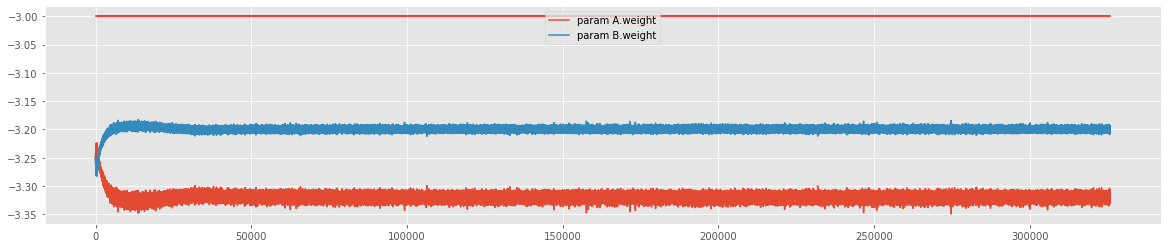

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 4))
legends = []
for i, (name, p) in enumerate(model.named_parameters()):
    plt.plot([ratios[j][i] for j in range(len(ratios))])
    legends.append('param {}'.format(name))
plt.plot([0, len(ratios)], [-3, -3], 'r')
plt.legend(legends)

How do you make sure the learing rate is good? Look at the above plots and suppose we have $log(LR * ratio) = -5$. Then $LR * ratio = 10^{-5}$. Assuming the ratio does not vary much, this probably means we need to increase the learing rate $LR$. Similarly for a reverse direction.